In [224]:
import numpy as np
import torch
import seaborn as sns
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy import stats
import copy
import glob
import os
import pickle
from invoke import run

In [3]:
#model = torch.load('/checkpoint/dieuwkehupkes/mt-data/en-nl/opus-taboeta/checkpoints/base_all_1/checkpoint_best.pt')

### Global Attention Metric

In [4]:
def flatten(t):
    return [item for sublist in t for item in sublist]

def get_positions_distances_mat(length, negative=False):
    '''
    For length 4:
    distance matrix = [[1,2,3,4],[2,1,2,3],[3,2,1,2],[4,3,2,1]]
    '''
    
    distances_matrix = np.zeros((length,length))
    tri = flatten([list(np.arange(i)+1) for i in range(length-1,0,-1)])
    distances_matrix[np.triu_indices(length,1)] = tri
    if not negative:
        distances_matrix += distances_matrix.T
    else:
        distances_matrix -= distances_matrix.T
    
    if not negative: 
        return torch.tensor(distances_matrix) + 1
    else:
        return torch.tensor(distances_matrix)
    
print(get_positions_distances_mat(4))
print(get_positions_distances_mat(4,True))

tensor([[1., 2., 3., 4.],
        [2., 1., 2., 3.],
        [3., 2., 1., 2.],
        [4., 3., 2., 1.]], dtype=torch.float64)
tensor([[ 0.,  1.,  2.,  3.],
        [-1.,  0.,  1.,  2.],
        [-2., -1.,  0.,  1.],
        [-3., -2., -1.,  0.]], dtype=torch.float64)


In [5]:
def calc_global_metric(attn_mat):
    '''
    Calculate a metric to estimate how much a given attntion head is global in thier weights.
    For a given head, the calculation is a mean weighted sum for every token.
    The score for token in position i = sum_{for every token in position j}(a/num_of_tokens)
    
    A score of 1.0 is completely global, a score of 1/num_of_tokens is completely local.
    '''
    
    cur_max_position = attn_mat.shape[-1] # maximal number of tokens
    distances_matrix = get_positions_distances_mat(cur_max_position).to(attn_mat.device) # global weights, the higher the more global
    
    # normlize weights to sum to 1.0, in case they don't (in remove EOS)
    norm_attn_mat = attn_mat / attn_mat.sum(dim=1).unsqueeze(1).expand(attn_mat.shape)
    
    sum_mat = torch.sum(distances_matrix*norm_attn_mat,axis=len(norm_attn_mat.shape)-1)
    normalized_weight_distanced = sum_mat / (cur_max_position + 1) # normlize score according to length so max is 1
    
    return normalized_weight_distanced.mean(-1)
    

In [6]:
bla = torch.tensor([[0.1,0.8],[0.4,0.6],[0.2,0.3]])
bla / bla.sum(dim=1).unsqueeze(1).expand(bla.shape)

tensor([[0.1111, 0.8889],
        [0.4000, 0.6000],
        [0.4000, 0.6000]])

## Attention Matrix Processing

#### Create Avg Matrix for a range of samples

In [7]:
def get_batch_sample_attn_matrix_load(sample_num, model_attn_dir):
    '''Stack attn_matrix of all layers to a single matrix that belong to one sample'''
    sample_attn_matrix = torch.zeros(NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)
    layers_matricies = []
    
    if torch.load(model_attn_dir + f'/batch_sample_attn_mat_0.pt').shape[0] == 8: # batch size 1
        for i in range(NUM_LAYERS):
            cur_index = sample_num*NUM_LAYERS + i
            layers_matricies.append(torch.load(model_attn_dir + f'/batch_sample_attn_mat_{cur_index}.pt'))
        sample_mat = torch.stack(layers_matricies, dim=0)
    else: # batch size is 128
        batch_size = int(torch.load(model_attn_dir + f'/batch_sample_attn_mat_0.pt').shape[0]/NUM_HEADS)
        print(f"batch_size={batch_size}")
        for i in range(NUM_LAYERS):
            cur_index = int(sample_num / batch_size)*NUM_LAYERS + i
            print(f"cur_index={cur_index}")
            loaded_mat = torch.load(model_attn_dir + f'/batch_sample_attn_mat_{cur_index}.pt')
            print("sample_attn_mat_ shape:",loaded_mat.shape)
            
            index_in_matrix = (sample_num % batch_size)*NUM_HEADS
            print(f"index_in_matrix={index_in_matrix}")
            layers_matricies.append(loaded_mat[index_in_matrix:index_in_matrix+NUM_HEADS,:,:])
#             indexes_in_matrix = list(range(sample_num % batch_size,NUM_HEADS*batch_size,batch_size))
#             print(f"indexes_in_matrix={indexes_in_matrix}")
#             layers_matricies.append(loaded_mat[indexes_in_matrix,:,:])
            
        sample_mat = torch.stack(layers_matricies, dim=0)
        print(f"sample_mat.shape[-1]={sample_mat.shape[-1]}")
    
    sample_attn_matrix[:,:,:sample_mat.shape[-1],:sample_mat.shape[-1]] = sample_mat
    
    #return sample_attn_matrix
    return layers_matricies

# def get_sample_attn_matrix_load(sample_num, model_attn_dir):
#     '''Stack attn_matrix of all layers to a single matrix that belong to one sample'''
#     sample_attn_matrix = torch.zeros(NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)
#     layers_matricies = []
    
#     batch_size_times_heads = get_batch_size_times_heads(model_attn_dir)
    
#     if batch_size_times_heads == NUM_HEADS: # batch size 1
#         for i in range(NUM_LAYERS):
#             cur_index = sample_num*NUM_LAYERS + i
#             #print(f"cur_index={cur_index}")
#             #print("sample_attn_mat_ shape:",torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt').shape)
#             layers_matricies.append(torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt'))
#         sample_mat = torch.stack(layers_matricies, dim=0)
#         #print(f"sample_mat.shape[-1]={sample_mat.shape[-1]}")
    
#     sample_attn_matrix[:,:,:sample_mat.shape[-1],:sample_mat.shape[-1]] = sample_mat
    
#     return sample_attn_matrix
    #return layers_matricies

In [103]:
def get_sample_attn_matrix_load(sample_num, model_attn_dir):
    '''Stack attn_matrix of all layers to a single matrix that belong to one sample'''
    sample_attn_matrix = torch.zeros(NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)
    layers_matricies = []
    
    batch_size_times_heads = get_batch_size_times_heads(model_attn_dir)
    if batch_size_times_heads == NUM_HEADS: # batch size 1
        #print("batch size 1")
        for i in range(NUM_LAYERS):
            cur_index = sample_num*NUM_LAYERS + i
            layers_matricies.append(torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt'))
        sample_mat = torch.stack(layers_matricies, dim=0)
    else: # batch size is 128
        batch_size = int(torch.load(model_attn_dir + f'/sample_attn_mat_0.pt').shape[0]/NUM_HEADS)
        #print(f"batch_size={batch_size}")
        for i in range(NUM_LAYERS):
            cur_index = int(sample_num / batch_size)*NUM_LAYERS + i
            #print(f"cur_index={cur_index}")
            loaded_mat = torch.load(model_attn_dir + f'/sample_attn_mat_{cur_index}.pt')
            index_in_matrix = (sample_num % batch_size)*NUM_HEADS
            #print(f"index_in_matrix={index_in_matrix}")
            layers_matricies.append(loaded_mat[index_in_matrix:index_in_matrix+NUM_HEADS,:,:])
        sample_mat = torch.stack(layers_matricies, dim=0)
        #print(f"sample_mat.shape[-1]={sample_mat.shape[-1]}")
    
    sample_attn_matrix[:,:,:sample_mat.shape[-1],:sample_mat.shape[-1]] = sample_mat
    
    return sample_attn_matrix

def get_batch_size_times_heads(model_attn_dir):
    try:
        sample_matrix = torch.load(model_attn_dir + f'/sample_attn_mat_0.pt')
        batch_size_times_heads = sample_matrix.shape[0]
    except Exception as e:
        list_of_files = glob.glob(f'{model_attn_dir}/avg_attn_mat*') 
        latest_avg_matrix = max(list_of_files, key=os.path.getctime)
        #batch_size_times_heads = int(latest_avg_matrix.split('avg_attn_mat_')[1][:2].replace('_','')) # get the length from the avg mat file name
        sample_matrix = torch.load(latest_avg_matrix)
        batch_size_times_heads = sample_matrix.shape[1]
    return batch_size_times_heads

def delete_sample_range_attn_mat(model_attn_dir,samples_range):
    batch_size_times_heads = get_batch_size_times_heads(model_attn_dir)
    for sample_num in range(samples_range[0], samples_range[1]+1):
        #print(f"Trying to delete: {sample_num} {model_attn_dir} batch_size_times_heads={batch_size_times_heads} NUM_HEADS={NUM_HEADS}")
        if batch_size_times_heads == NUM_HEADS: # batch size 1
            for i in range(NUM_LAYERS):
                cur_index = sample_num*NUM_LAYERS + i
                #print(f"Trying to delete cur_index: {model_attn_dir}/sample_attn_mat_{cur_index}.pt")
                if os.path.exists(f'{model_attn_dir}/sample_attn_mat_{cur_index}.pt'):
                    #print(f"deleteing... {model_attn_dir}/sample_attn_mat_{cur_index}.pt")
                    os.remove(f'{model_attn_dir}/sample_attn_mat_{cur_index}.pt')
           
        
def get_avg_attn_matrix_load(samples_range, length, NUM_SAMPLES, model_attn_dir, size, cond, cond_name, text_type,recompte_avg_attn_mat=False):
    range_name = str(samples_range).replace(' ','_')
    saving_name = model_attn_dir + f'/avg_attn_mat_{length}_{range_name}_{size}_{cond}_{cond_name}_{text_type}.pt'
    if not recompte_avg_attn_mat:
        try:
            #print(f"Trying to load: {saving_name}")
            res = torch.load(saving_name)
            # print(f"Using saved avg matrix at {saving_name}")
            # delete_sample_range_attn_mat(model_attn_dir,samples_range)
            return res
        except Exception as e:
            print(f"Exception is:{e}")
            print("No saved avg matrix, calculating and saving")
    print(f"Computing avg matrix for {saving_name}...")

    sum_attn_weights = torch.zeros((NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)) # layers X attn_heads X max_position X max_position
    devision_matrix = torch.zeros((NUM_LAYERS,NUM_HEADS,MAX_POSITION,MAX_POSITION)) # layers X attn_heads X max_position X max_position

    # print(f"Sample Range:{samples_range}")
    for sample_num in range(samples_range[0], samples_range[1]+1):
        # print(f"sample_num:{sample_num}")
        sample_attn_matrix = get_sample_attn_matrix_load(sample_num, model_attn_dir)

#         if sample_num < samples_range[0]:
#             continue
#         #print(f"{sample_num}", end=",")
#         if sample_num > samples_range[1]:
#             break

        sum_attn_weights += sample_attn_matrix
        devision_matrix[sample_attn_matrix!=0] += 1

    devision_matrix[devision_matrix==0] = 1
    res = sum_attn_weights/devision_matrix
    
    torch.save(res, saving_name)
    print(f"Saved avg matrix at {saving_name}")
    # delete_sample_range_attn_mat(model_attn_dir,samples_range)
    return res

def is_eos_focused(sample_attn_matrix):
    weight_threshold = 0.20 # 2*1/LENGTH
    majority_threshold = 0.80
    eos_above_threshold = torch.sum(sample_attn_matrix[:,-1] > weight_threshold)
    return (eos_above_threshold / sample_attn_matrix.shape[-1]) > majority_threshold
    

def get_avg_attn_matrix_across_heads(samples_heads_list, LENGTH, model_attn_dir, ignore_eos=False):
    sum_attn_weights = torch.zeros((LENGTH,LENGTH)) 
    devision_matrix = torch.zeros((LENGTH,LENGTH)) 

    for score,sample_num,layer,head in samples_heads_list:
        sample_attn_matrix = get_sample_attn_matrix_load(sample_num, model_attn_dir)
        #print(f"sample_attn_matrix.shape:{sample_attn_matrix.shape}")
        sample_attn_matrix = sample_attn_matrix[layer][head][:LENGTH,:LENGTH]
        #print(f"sample_attn_matrix.shape:{sample_attn_matrix.shape}")
        #print(f"sum_attn_weights.shape:{sum_attn_weights.shape}")
        if ignore_eos and is_eos_focused(sample_attn_matrix):
            continue
        sum_attn_weights += sample_attn_matrix
        devision_matrix[sample_attn_matrix!=0] += 1
    
    print(f"Number of matrices averaged upon: {devision_matrix[0][0]}")
    
    devision_matrix[devision_matrix==0] = 1
    return sum_attn_weights/devision_matrix

#### Util Functions

In [98]:
def get_samples_from_prints():
    all_samples = dict()
    with open(fname, 'r') as f:
        sample_num = 0
        line = f.readline()
        while len(line) != 0: # not EOF
            if '</s>' in line:
                all_samples[sample_num] = line
                #print(str(sample_num)+line)
                sample_num += 1
            line = f.readline()
    return all_samples
                            
def get_all_samples_dict(fname):
    if "attn_weights2.txt" in fname:
        print("getting samples dict from: attn_weights2.txt")
        return get_samples_from_prints()
    print(f"getting samples dict from: {fname}")
    all_samples = dict()
    with open(fname, 'r') as f:
        sample_num = 0
        line = f.readline()
        while len(line) != 0: # not EOF
            if 'S-' in line:
                all_samples[sample_num] = line.split(' ')#[1:]
                #print(str(sample_num)+line)
                sample_num += 1
            line = f.readline()
    return all_samples

def get_sample_len(sample_num, model_attn_dir, num_of_samples):
    try:
        sample_matrix = torch.load(model_attn_dir + f'/sample_attn_mat_{sample_num}.pt')
    except Exception as e: # there's exists a saved lengths dict
        lengths_dict = get_samples_lengths_dict(num_of_samples, model_attn_dir)
        
        for length in lengths_dict.keys():
            loading_name = f'{model_attn_dir}/{length}_range_tuple.pt'
            loaded_range = torch.load(loading_name)
            if (loaded_range[length][0] <= sample_num) or (sample_num <= loaded_range[length][1]):
                return length
    
    if sample_matrix.shape[0] == 8: # batch size 1
        index = sample_num*NUM_LAYERS
    else: # batch size 128
        batch_size = int(torch.load(model_attn_dir + f'/sample_attn_mat_{sample_num}.pt').shape[0]/NUM_HEADS)
        index = int(sample_num / batch_size)*NUM_LAYERS 
    attn_mat = torch.load(model_attn_dir+f'/sample_attn_mat_{index}.pt')
    return attn_mat.shape[-1]

def display_sample(LAYER, HEAD, sample_num, all_samples, model_attn_dir, print_out=True):
    sample_attn_matrix = get_sample_attn_matrix_load(sample_num, model_attn_dir)
    sample, sample_len = all_samples[sample_num].copy(), get_sample_len(sample_num, model_attn_dir, len(all_samples))
    
    sample[0] = sample[0].split('\t')[1]
    sample[-1] = '.'
    sample.append('EOS')


    gm_score = calc_global_metric(sample_attn_matrix[LAYER][HEAD][:sample_len,:sample_len]).item()
    w_median = get_mean_distance_weighted_median(sample_attn_matrix[LAYER][HEAD][:sample_len,:sample_len])
    
    if print_out:
        print(' '.join(sample))
        print(f"LAYER={LAYER}, HEAD={HEAD}")
        ax = sns.heatmap(sample_attn_matrix[LAYER][HEAD][:sample_len,:sample_len], xticklabels=sample, yticklabels=sample)
 
        ax.set(title="Attention Heatmap",
          xlabel="Attention To",
          ylabel="Attention From",)
        
        plt.rcParams["figure.figsize"] = (6,4.5)
        plt.show()
        print("Global Metric = {:.2f}".format(gm_score))
        print("Weighted Median = {:.2f}".format(w_median))
    
    return gm_score, w_median 
    
def get_samples_lengths_dict(num_of_samples, model_attn_dir):
    saving_name = f'{model_attn_dir}/lengths_dict.pt'
    if os.path.exists(saving_name):
        print(f"Loading lengths_dict from: {model_attn_dir}")
        return torch.load(saving_name)
                          
    print(f"Creating new lengths_dict for: {model_attn_dir}")
    samples_legnth = dict()
    for sample_num in range(num_of_samples):
        cur_len = get_sample_len(sample_num, model_attn_dir, num_of_samples)
        if cur_len in samples_legnth:
            samples_legnth[cur_len] += 1
        else:
            samples_legnth[cur_len] = 1
                          
    torch.save(samples_legnth,saving_name)
    return samples_legnth

    
def get_samples_range(target_length, num_of_samples, model_attn_dir):
    saving_name = f'{model_attn_dir}/{target_length}_range_tuple.pt'
    if os.path.exists(saving_name):
        return torch.load(saving_name)[target_length]
    
    samples_cur_legnth = []
    for sample_num in range(num_of_samples):
        cur_len = get_sample_len(sample_num, model_attn_dir, num_of_samples)    
        #print(f"sample_num:{sample_num} | cur_len:{cur_len}")
        if cur_len == target_length:
            samples_cur_legnth.append(sample_num)
    if len(samples_cur_legnth) == 0:
        raise Exception(f'No samples found with length {target_length} for model at {model_attn_dir}.')
    res = {target_length: (samples_cur_legnth[0],samples_cur_legnth[-1])}
    torch.save(res, saving_name)
    return res[target_length]

def get_bleu_score(trained_model, size):
    list_of_files = glob.glob(f'/checkpoint/itayitzhak/trained_models/opus/{size}/{trained_model}/eval*out*') 
    latest_file = max(list_of_files, key=os.path.getctime)
    with open(latest_file, 'r') as f:
        for line in f.readlines():
            if 'BLEU4' in line:
                return float(line.split('BLEU4')[1][3:8].strip().replace(',',''))
    return None

In [99]:
def weighted_median(data, weights):
    """
    Args:
      data (list or numpy.array): data
      weights (list or numpy.array): weights
    
    returns the weighted median in data according to weights (float)
    """
    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median
    
def get_mean_distance_weighted_median(attn_mat):
    num_of_tokens = attn_mat.shape[0]
    dists = get_positions_distances_mat(num_of_tokens,negative=True)
    #sum_of_weighted_medians = 0
    all_weighted_medians = []
    for index_token in range(num_of_tokens):
        cur_weighted_median = weighted_median(dists[index_token], attn_mat[index_token]/sum(attn_mat[index_token])) # scale weights to sum to 1.0 if they are not (in remove EOS)
        # sum_of_weighted_medians += abs(cur_weighted_median)
        all_weighted_medians.append(abs(cur_weighted_median))
    return np.percentile(all_weighted_medians, 90)

## Analysis

#### Compare sampels from different model evaluation

In [11]:
# LAYER = 5
# HEAD = 0
# sample_num = 100

# seed_mod = '1'
# seed_data = '1'
# size = 'all' # 'all'
# cond = 's_conj' #'s_np_vp'
# cond_name = 's1_s2'#'np'
# data_type = 'synthetic' #'semi_natural' #'natural'
# premuted_prefix = 'compositional_mt_'#'permuted_data_' # ''
# premuted_suffix = ''#'_3gram' # ''
# LENGTH = 17
# NUM_HEADS = 8\\
# NUM_LAYERS = 6
# MAX_POSITION = 1024
# #############################
# cur_model_path = f'/checkpoint/itayitzhak/attn_weigths/{premuted_prefix}systematicity_{cond}_{data_type}_systematicity_{data_type}_{seed_data}_{cond_name}{premuted_suffix}_{size}'
# #cur_model_pred = f'/checkpoint/itayitzhak/attn_weigths/systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all/generate-test.txt'
# cur_model_pred = f'/checkpoint/itayitzhak/attn_weigths/compositional_mt_systematicity_{cond}_{data_type}_systematicity_{data_type}_{seed_data}_{cond_name}_all/generate-test.txt'
# if 'permuted' in premuted_prefix:
#     cur_model_pred = f'/checkpoint/itayitzhak/permuted_data/systematicity/{cond}/{data_type}/systematicity_{data_type}_{seed_data}_{cond_name}{premuted_suffix}/all/pred.txt/generate-test.txt'
# all_samples = get_all_samples_dict(cur_model_pred)

# NUM_SAMPLES = len(all_samples)

# Per sample
# display_sample(LAYER, HEAD, sample_num, all_samples, cur_model_path)
# #bla = cur_model_path.split('/')[-1]
# print(f"Model:{cur_model_path}")
# print(f"Predi:{cur_model_pred}")

In [1578]:
# Per layer
# LAYER = 4
#sns.heatmap(avg_attn_matrix[LAYER].mean(dim=0)[:LENGTH,:LENGTH])

In [12]:
# Per head
# LAYER = 4
# HEAD = 7
# sns.heatmap(avg_attn_matrix[LAYER][HEAD][:LENGTH,:LENGTH])
# print("Global Metric = {:.2f}".format(calc_global_metric(avg_attn_matrix[LAYER][HEAD][:LENGTH,:LENGTH]).item()))

### Percentage Score Per Model

In [13]:
#print(weighted_median([2,1,0,1,2,3],[0.12,0.01,0.01,0.01,0.0,0.85])) # 3
#print(weighted_median([2,1,0,1,2,3],[0.5,0.01,0.01,0.01,0.0,0.47])) # 2
#print(weighted_median([2,1,0,1,2],[0.9,0.01,0.01,0.01,0.07])) # 2
#print(weighted_median([2,1,0,1,2],[0.5,0.01,0.01,0.01,0.47])) # 2
#print(weighted_median([2,1,0,1,2],[0.01,0.5,0.01,0.01,0.47])) # 1
#print(weighted_median([2,1,0,1,2],[0.01,0.5,0.01,0.47,0.01])) # 1
#print(weighted_median([2,1,0,1,2],[0.01,0.01,0.5,0.47,0.01])) # 0.5
#get_mean_distance_weighted_median(torch.tensor([[0.5,0.5,0.0],[0.1,0.8,0.1],[0.95,0.05,0.05]]))

In [100]:
def get_model_wmd_gloablity_scores(attn_mat, LENGTH, with_eos=True):
    distance_weighted_median = []
    globality_scores = []
    for i in range(NUM_LAYERS):
        for j in range(NUM_HEADS):
            cur_head = attn_mat[i][j][:LENGTH,:LENGTH]
            if not with_eos:
                cur_head = cur_head[:-1,:-1]
            distance_weighted_median.append(get_mean_distance_weighted_median(cur_head))
            globality_scores.append(calc_global_metric(cur_head).item())
    
    model_distance_weighted_median = sum(distance_weighted_median)/len(distance_weighted_median)
    model_globality_scores = sum(globality_scores)/len(globality_scores)
    return model_globality_scores, model_distance_weighted_median
    

def calc_percentage_of_attn_head_type(attn_mat, LENGTH, weight_threshold=0.35, majority_threshold=0.9):
#     print(f"Attention Weight threshold is: {weight_threshold:.2f}.")
#     print(f"Majority threshold is: {majority_threshold:.1f}.")
    num_of_eos_foucesed_heads = 0
    num_of_local_heads = 0
    num_of_self_heads = 0
    
    eos_foucesed_heads = []
    self_heads = []
    local_heads = []
    distance_weighted_median = []
    globality_scores = []
    
    for i in range(NUM_LAYERS):
        for j in range(NUM_HEADS):
            cur_head = attn_mat[i][j][:LENGTH,:LENGTH]
            
            # EOS-focused
            eos_foucesed_heads.append(np.percentile(cur_head[:,-1], 90))
            eos_above_threshold = torch.sum(cur_head[:,-1] > weight_threshold)
            #eos_foucesed_heads.append(torch.mean(cur_head[:,-1]))
            if (eos_above_threshold / cur_head.shape[-1]) > majority_threshold:
                num_of_eos_foucesed_heads += 1
                
            # Self-focused
            #print(sorted([x.item() for x in cur_head.diagonal()]))
            self_heads.append(np.percentile(cur_head.diagonal(), 90))
            self_above_threshold = torch.sum(cur_head.diagonal() > weight_threshold)
            if (self_above_threshold / cur_head.shape[-1]) > majority_threshold:
                num_of_self_heads += 1
                
            # Local-focused
            local_mean = (cur_head.diagonal()[1:-1] + cur_head.diagonal(1)[1:] + cur_head.diagonal(-1)[:-1])#/3
            pos_first_local_mean = (cur_head.diagonal()[0] + cur_head.diagonal(1)[0]) #/ 2
            pos_last_local_mean = (cur_head.diagonal()[-1] + cur_head.diagonal(-1)[-1]) #/ 2
            local_mean = torch.cat([pos_first_local_mean.unsqueeze(0),local_mean,pos_last_local_mean.unsqueeze(0)])
            
            local_mean -= cur_head.diagonal() # do not include self attention
            
            local_heads.append(np.percentile(local_mean, 90))
            local_above_threshold = torch.sum(cur_head.diagonal() > weight_threshold)
            if (local_above_threshold / cur_head.shape[-1]) > majority_threshold:
                num_of_local_heads += 1
            
            # Weighted median distance & Globality
            distance_weighted_median.append(get_mean_distance_weighted_median(cur_head))
            globality_scores.append(calc_global_metric(cur_head).item())

    # print(f"For data \"{cond}\" \"{cond_name}\" Training_data_size=\"{size}\" with sentences in Length=\"{LENGTH}\" the measures are:")
#     print("Percentage of EOS focused heads:  {:.2%}".format(num_of_eos_foucesed_heads/(NUM_LAYERS*NUM_LAYERS)))
#     print("Percentage of self focused heads: {:.2%}".format(num_of_self_heads/(NUM_LAYERS*NUM_LAYERS)))
#     print("Percentage of Local focused heads: {:.2%}".format(num_of_local_heads/(NUM_LAYERS*NUM_LAYERS)))
    
    return eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores
    

In [302]:
def get_seed_final_results(curr_model_final_results, seed, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, is_with_eos, consistency_only):
    cur_model_path = f'/checkpoint/itayitzhak/attn_weigths/{trained_data_type}_seed_{seed}_{premuted_prefix}systematicity_{conds[0]}_{text_type}_systematicity_{text_type}_{template}_{conds[1]}{premuted_suffix}_{trained_data_size}'
    cur_model_pred = cur_model_path + f'/generate-test.txt'

    if conds[0] == 's_conj':# and cond_name == 's1p':
        (s1p, s3), _ = compute_systematicity_s_conj(template, seed, trained_data_type, text_type, trained_data_size)
        curr_model_final_results['s_conj_s1p_s2_consist'].append(s1p)
        curr_model_final_results['s_conj_s3_s2_consist'].append(s3)
    elif conds[0] == 's_np_vp':
        (score_np, score_vp), _ = compute_systematicity_s_np_vp(template, seed, trained_data_type, text_type, trained_data_size)
        curr_model_final_results['s_np_vp_np_prime_consist'].append(score_np)
        curr_model_final_results['s_np_vp_vp_prime_consist'].append(score_vp)
        
    if consistency_only:
        return curr_model_final_results

    curr_seed_model_wmd = []
    curr_seed_model_glob = []
    
    all_samples = get_all_samples_dict(cur_model_pred)
    NUM_SAMPLES = len(all_samples)
    lengths_dict = get_samples_lengths_dict(NUM_SAMPLES, cur_model_path)
    print(f"lengths_dict:{lengths_dict}")

    for length in lengths_dict.keys():
        LENGTH = length
        samples_range = get_samples_range(LENGTH, NUM_SAMPLES, cur_model_path)
        avg_attn_matrix = get_avg_attn_matrix_load(samples_range, length, NUM_SAMPLES, cur_model_path, trained_data_size, conds[0], conds[1], text_type, recompte_avg_attn_mat)
        g, w = get_model_wmd_gloablity_scores(avg_attn_matrix, LENGTH, with_eos=is_with_eos)
        eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores = calc_percentage_of_attn_head_type(
        avg_attn_matrix, LENGTH)

        curr_model_final_results['eos_foucesed_heads'].append(eos_foucesed_heads)
        curr_model_final_results['self_heads'].append(self_heads)
        curr_model_final_results['local_heads'].append(local_heads)
        curr_model_final_results['distance_weighted_median'].append(distance_weighted_median)
        curr_model_final_results['globality_scores'].append(globality_scores)

        curr_seed_model_wmd.append(w)
        curr_seed_model_glob.append(g)

    curr_model_final_results['model_bleu'].append(get_bleu_score(f'{trained_data_type}_seed_{seed}', trained_data_size))
    curr_model_final_results['model_distance_weighted_median'].append(np.average(curr_seed_model_wmd, weights=list(lengths_dict.values())))
    curr_model_final_results['model_globality_scores'].append(np.average(curr_seed_model_glob, weights=list(lengths_dict.values())))
    
    return curr_model_final_results
    
    
def get_model_final_results(all_seeds, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, consistency_only):
    curr_model_final_results = {'eos_foucesed_heads':[],
                                'self_heads':[],
                                'local_heads':[],
                               'distance_weighted_median':[],
                                'globality_scores':[],
                               'trained_data_type':trained_data_type,
                               'trained_data_size':trained_data_size,
                               'conds':conds,
                               'text_type':text_type,
                                'template': template,
                               'model_bleu':[],
                               'model_distance_weighted_median':[],
                               'model_globality_scores':[],}

    size = trained_data_size
    cond = conds[0]
    cond_name = conds[1]

    if cond == 's_conj': # and cond_name == 's1p':
        curr_model_final_results['s_conj_s1p_s2_consist'] = []
        curr_model_final_results['s_conj_s3_s2_consist'] = []
    elif cond == 's_np_vp':
        curr_model_final_results['s_np_vp_np_prime_consist'] = []
        curr_model_final_results['s_np_vp_vp_prime_consist'] = []

    if trained_data_type == 'not_permuted_without_eos':
        trained_data_type = 'not_permuted'
        is_with_eos = False
    else:
        is_with_eos = True

#     if trained_data_type == 'not_permuted' and (trained_data_size == 'tiny' or trained_data_size == 'small'):
#         if all_seeds == [1,2,3]:
#             all_seeds = [2,3]

    for seed in all_seeds:
        try:
            curr_model_final_results = get_seed_final_results(curr_model_final_results.copy(), seed, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, is_with_eos, consistency_only)
        except Exception as e:
            print(e)
            print(f"Missed111:{(curr_model_final_results, seed, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, is_with_eos)}")

#     for key in ['eos_foucesed_heads', 'self_heads', 'local_heads', 'distance_weighted_median', 'globality_scores']:
#         curr_model_final_results[key] = curr_model_final_results[key]

    return curr_model_final_results


def get_all_models_final_results(all_data_types,all_data_sizes,all_text_type,all_conds,all_seeds,all_templates,recompte_avg_attn_mat=True, consistency_only=False):
    all_models_final_results = dict()
    # seed_mod = '1'
    # template = '1'
    # cond = 's_conj' #'s_np_vp'
    # cond_name = 's1_s2'#'np'
    # text_type = 'synthetic' #'semi_natural' #'natural'
    premuted_prefix = 'compositional_mt_'#'permuted_data_' #'compositional_mt_' for non-permuted#
    premuted_suffix = ''#'_3gram' # ''
    
    saving_name = f'/checkpoint/itayitzhak/attn_weigths/all_models_final_results_{str(all_data_types)}_{str(all_data_sizes)}_{str(all_text_type)}_{str(all_conds)}_{str(all_seeds)}_{str(all_templates)}_{str(recompte_avg_attn_mat)}'
#     if os.path.exists(saving_name):
#         return torch.load(saving_name)
    i = 0
    for trained_data_size, trained_data_type, text_type, conds, template in list(
        itertools.product(all_data_sizes, all_data_types, all_text_type, all_conds, all_templates)):
        curr_model_final_results = get_model_final_results(all_seeds, trained_data_size, trained_data_type, text_type, conds, template, premuted_prefix, premuted_suffix, consistency_only)
        model_name_to_save = f"{curr_model_final_results['trained_data_type']}_{trained_data_size}_{text_type}_{conds}_{template}_{premuted_prefix}_{premuted_suffix}"
        # cur_model_path = f'/checkpoint/itayitzhak/attn_weigths/{trained_data_type}_seed_{seed}_{premuted_prefix}systematicity_{conds[0]}_{text_type}_systematicity_{text_type}_{template}_{conds[1]}{premuted_suffix}_{trained_data_size}'
        all_models_final_results[model_name_to_save] = curr_model_final_results
        print('='*100)
        i += 1
        print(f"Model {i}/{len(list(itertools.product(all_data_sizes, all_data_types, all_text_type, all_conds, all_templates)))}")
        print('='*100)
    
    torch.save(all_models_final_results,saving_name)
    return all_models_final_results

In [320]:
# all_data_types = ["not_permuted", '5gram_permuted', "permuted"]
all_data_types = ["not_permuted", 'remove_eos_not_permuted', 'not_permuted_without_eos']#["not_permuted"]###['remove_eos_not_permuted']#
#all_data_types = ['remove_eos_not_permuted']
all_data_sizes = ['tiny','small','all']#['tiny']#
#all_data_sizes = ['all']
all_seeds = [1,2,3,4,5]
#all_seeds = [3]
all_text_type = ['synthetic'] #'semi_natural' #'natural'

all_templates = [1,2,3,4,5,6,7,8,9,10]
#all_templates = [2]
#all_conds = [('s_conj','s1_s2')]
#all_conds = [('s_conj','s1_s2'),('s_conj','s3_s2'),('s_np_vp', 'np')]
all_conds = [('s_conj','s1_s2'),('s_np_vp', 'np')]

NUM_HEADS = 8
NUM_LAYERS = 6
MAX_POSITION = 50

recompte_avg_attn_mat = True
consistency_only = True

if consistency_only:
    cons_all_models_final_results = get_all_models_final_results(all_data_types,all_data_sizes,all_text_type,all_conds,all_seeds,all_templates,recompte_avg_attn_mat, consistency_only)
else:
    all_models_final_results = get_all_models_final_results(all_data_types,all_data_sizes,all_text_type,all_conds,all_seeds,all_templates,recompte_avg_attn_mat, consistency_only)
#saving_name = f"all_models_final_results_{str(all_data_types).replace(' ','')}_{str(all_data_sizes).replace(' ','')}_{str(all_text_type).replace(' ','')}_{str(all_conds).replace(' ','')}_{str(all_seeds).replace(' ','')}_{str(all_templates).replace(' ','')}"
#pickle.dump(all_models_final_results, open("/checkpoint/itayitzhak/.p", "wb"))

[1, 2, 3, 4, 5]
Model 1/180
[1, 2, 3, 4, 5]
Model 2/180
[1, 2, 3, 4, 5]
Model 3/180
[1, 2, 3, 4, 5]
Model 4/180
[1, 2, 3, 4, 5]
Model 5/180
[1, 2, 3, 4, 5]
Model 6/180
[1, 2, 3, 4, 5]
Model 7/180
[1, 2, 3, 4, 5]
Model 8/180
[1, 2, 3, 4, 5]
Model 9/180
[1, 2, 3, 4, 5]
Model 10/180
[1, 2, 3, 4, 5]
Model 11/180
[1, 2, 3, 4, 5]
Model 12/180
[1, 2, 3, 4, 5]
Model 13/180
[1, 2, 3, 4, 5]
Model 14/180
[1, 2, 3, 4, 5]
Model 15/180
[1, 2, 3, 4, 5]
Model 16/180
[1, 2, 3, 4, 5]
Model 17/180
[1, 2, 3, 4, 5]
Model 18/180
[1, 2, 3, 4, 5]
Model 19/180
[1, 2, 3, 4, 5]
Model 20/180
[1, 2, 3, 4, 5]
Model 21/180
[1, 2, 3, 4, 5]
Model 22/180
[1, 2, 3, 4, 5]
Model 23/180
[1, 2, 3, 4, 5]
Model 24/180
[1, 2, 3, 4, 5]
Model 25/180
[1, 2, 3, 4, 5]
Model 26/180
[1, 2, 3, 4, 5]
Model 27/180
[1, 2, 3, 4, 5]
Model 28/180
[1, 2, 3, 4, 5]
not enough values to unpack (expected 2, got 0)
Missed111:({'eos_foucesed_heads': [], 'self_heads': [], 'local_heads': [], 'distance_weighted_median': [], 'globality_scores': [], 't

Model 34/180
[1, 2, 3, 4, 5]
Model 35/180
[1, 2, 3, 4, 5]
Model 36/180
[1, 2, 3, 4, 5]
Model 37/180
[1, 2, 3, 4, 5]
Model 38/180
[1, 2, 3, 4, 5]
Model 39/180
[1, 2, 3, 4, 5]
Model 40/180
[1, 2, 3, 4, 5]
Model 41/180
[1, 2, 3, 4, 5]
Model 42/180
[1, 2, 3, 4, 5]
Model 43/180
[1, 2, 3, 4, 5]
Model 44/180
[1, 2, 3, 4, 5]
Model 45/180
[1, 2, 3, 4, 5]
Model 46/180
[1, 2, 3, 4, 5]
Model 47/180
[1, 2, 3, 4, 5]
Model 48/180
[1, 2, 3, 4, 5]
Model 49/180
[1, 2, 3, 4, 5]
Model 50/180
[1, 2, 3, 4, 5]
Model 51/180
[1, 2, 3, 4, 5]
Model 52/180
[1, 2, 3, 4, 5]
Model 53/180
[1, 2, 3, 4, 5]
Model 54/180
[1, 2, 3, 4, 5]
Model 55/180
[1, 2, 3, 4, 5]
Model 56/180
[1, 2, 3, 4, 5]
Model 57/180
[1, 2, 3, 4, 5]
Model 58/180
[1, 2, 3, 4, 5]
Model 59/180
[1, 2, 3, 4, 5]
Model 60/180
[1, 2, 3, 4, 5]
Model 61/180
[1, 2, 3, 4, 5]
Model 62/180
[1, 2, 3, 4, 5]
Model 63/180
[1, 2, 3, 4, 5]
Model 64/180
[1, 2, 3, 4, 5]
Model 65/180
[1, 2, 3, 4, 5]
Model 66/180
[1, 2, 3, 4, 5]
Model 67/180
[1, 2, 3, 4, 5]
Model 68/180
[

Model 72/180
[1, 2, 3, 4, 5]
Model 73/180
[1, 2, 3, 4, 5]
Model 74/180
[1, 2, 3, 4, 5]
Model 75/180
[1, 2, 3, 4, 5]
Model 76/180
[1, 2, 3, 4, 5]
Model 77/180
[1, 2, 3, 4, 5]
Model 78/180
[1, 2, 3, 4, 5]
Model 79/180
[1, 2, 3, 4, 5]
Model 80/180
[1, 2, 3, 4, 5]
Model 81/180
[1, 2, 3, 4, 5]
Model 82/180
[1, 2, 3, 4, 5]
Model 83/180
[1, 2, 3, 4, 5]
not enough values to unpack (expected 2, got 0)
Missed111:({'eos_foucesed_heads': [], 'self_heads': [], 'local_heads': [], 'distance_weighted_median': [], 'globality_scores': [], 'trained_data_type': 'remove_eos_not_permuted', 'trained_data_size': 'small', 'conds': ('s_conj', 's1_s2'), 'text_type': 'synthetic', 'template': 4, 'model_bleu': [], 'model_distance_weighted_median': [], 'model_globality_scores': [], 's_conj_s1p_s2_consist': [0.91, 0.942, 0.918, 0.922], 's_conj_s3_s2_consist': [0.716, 0.858, 0.804, 0.752]}, 5, 'small', 'remove_eos_not_permuted', 'synthetic', ('s_conj', 's1_s2'), 4, 'compositional_mt_', '', True)
Model 84/180
[1, 2, 3,

Model 106/180
[1, 2, 3, 4, 5]
Model 107/180
[1, 2, 3, 4, 5]
Model 108/180
[1, 2, 3, 4, 5]
Model 109/180
[1, 2, 3, 4, 5]
Model 110/180
[1, 2, 3, 4, 5]
Model 111/180
[1, 2, 3, 4, 5]
Model 112/180
[1, 2, 3, 4, 5]
Model 113/180
[1, 2, 3, 4, 5]
Model 114/180
[1, 2, 3, 4, 5]
Model 115/180
[1, 2, 3, 4, 5]
Model 116/180
[1, 2, 3, 4, 5]
Model 117/180
[1, 2, 3, 4, 5]
Model 118/180
[1, 2, 3, 4, 5]
Model 119/180
[1, 2, 3, 4, 5]
Model 120/180
[1, 2, 3, 4, 5]
Model 121/180
[1, 2, 3, 4, 5]
Model 122/180
[1, 2, 3, 4, 5]
Model 123/180
[1, 2, 3, 4, 5]
Model 124/180
[1, 2, 3, 4, 5]
Model 125/180
[1, 2, 3, 4, 5]
Model 126/180
[1, 2, 3, 4, 5]
Model 127/180
[1, 2, 3, 4, 5]
Model 128/180
[1, 2, 3, 4, 5]
Model 129/180
[1, 2, 3, 4, 5]
Model 130/180
[1, 2, 3, 4, 5]
Model 131/180
[1, 2, 3, 4, 5]
Model 132/180
[1, 2, 3, 4, 5]
Model 133/180
[1, 2, 3, 4, 5]
Model 134/180
[1, 2, 3, 4, 5]
Model 135/180
[1, 2, 3, 4, 5]
Model 136/180
[1, 2, 3, 4, 5]
Model 137/180
[1, 2, 3, 4, 5]
Model 138/180
[1, 2, 3, 4, 5]
Model 139/

Model 146/180
[1, 2, 3, 4, 5]
Model 147/180
[1, 2, 3, 4, 5]
Model 148/180
[1, 2, 3, 4, 5]
Model 149/180
[1, 2, 3, 4, 5]
Model 150/180
[1, 2, 3, 4, 5]
Model 151/180
[1, 2, 3, 4, 5]
Model 152/180
[1, 2, 3, 4, 5]
Model 153/180
[1, 2, 3, 4, 5]
Model 154/180
[1, 2, 3, 4, 5]
Model 155/180
[1, 2, 3, 4, 5]
Model 156/180
[1, 2, 3, 4, 5]
Model 157/180
[1, 2, 3, 4, 5]
Model 158/180
[1, 2, 3, 4, 5]
Model 159/180
[1, 2, 3, 4, 5]
Model 160/180
[1, 2, 3, 4, 5]
Model 161/180
[1, 2, 3, 4, 5]
Model 162/180
[1, 2, 3, 4, 5]
Model 163/180
[1, 2, 3, 4, 5]
Model 164/180
[1, 2, 3, 4, 5]
Model 165/180
[1, 2, 3, 4, 5]
Model 166/180
[1, 2, 3, 4, 5]
Model 167/180
[1, 2, 3, 4, 5]
Model 168/180
[1, 2, 3, 4, 5]
Model 169/180
[1, 2, 3, 4, 5]
Model 170/180
[1, 2, 3, 4, 5]
Model 171/180
[1, 2, 3, 4, 5]
Model 172/180
[1, 2, 3, 4, 5]
Model 173/180
[1, 2, 3, 4, 5]
Model 174/180
[1, 2, 3, 4, 5]
Model 175/180
[1, 2, 3, 4, 5]
Model 176/180
[1, 2, 3, 4, 5]
Model 177/180
[1, 2, 3, 4, 5]
Model 178/180
[1, 2, 3, 4, 5]
Model 179/

In [253]:
print(saving_name)

all_models_final_results_['not_permuted','remove_eos_not_permuted','not_permuted_without_eos']_['tiny','small','all']_['synthetic']_[('s_conj','s1_s2'),('s_np_vp','np')]_[1,2,3]_[1,2,3,4,5,6,7,8,9,10]


In [268]:
pickle.dump(all_models_final_results, open("/checkpoint/itayitzhak/all_models_final_results_templates.pt", "wb"))

In [306]:
for cur_model_path, results in cons_all_models_final_results.items():
    print(cur_model_path)
    for key, value in results.items():
        if key == 's_conj_s1p_s2_consist':
            print(key)
            print(value)
        if key == 's_conj_s3_s2_consist':
            print(key)
            print(value)
        if key == 'model_bleu':
#             if '1_compositional_mt' in cur_model_path:
#                 results['model_bleu'] = [80,90]
            print(key)
            print(value)

print("="*100)            
# for cur_model_path, results in temp_all_models_final_results.items():
#     print(cur_model_path)
#     for key, value in results.items():
#         if key == 'model_distance_weighted_median':
#             print(value)

not_permuted_tiny_synthetic_('s_conj', 's1_s2')_1_compositional_mt__
model_bleu
[]
s_conj_s1p_s2_consist
[0.8152610441767069, 0.8853118712273642, 0.8517034068136272, 0.8470824949698189, 0.8646464646464647]
s_conj_s3_s2_consist
[0.5080321285140562, 0.7082494969818913, 0.5951903807615231, 0.670020120724346, 0.6868686868686869]
not_permuted_tiny_synthetic_('s_conj', 's1_s2')_2_compositional_mt__
model_bleu
[]
s_conj_s1p_s2_consist
[0.6933867735470942, 0.7931726907630522, 0.7751004016064257, 0.7474949899799599, 0.7555555555555555]
s_conj_s3_s2_consist
[0.32665330661322645, 0.46184738955823296, 0.41967871485943775, 0.4028056112224449, 0.39595959595959596]
not_permuted_tiny_synthetic_('s_conj', 's1_s2')_3_compositional_mt__
model_bleu
[]
s_conj_s1p_s2_consist
[0.768, 0.748, 0.806, 0.808, 0.842]
s_conj_s3_s2_consist
[0.584, 0.558, 0.526, 0.532, 0.63]
not_permuted_tiny_synthetic_('s_conj', 's1_s2')_4_compositional_mt__
model_bleu
[]
s_conj_s1p_s2_consist
[0.816, 0.742, 0.8557114228456913, 0.88

In [322]:
sns.set_context("talk")
#results = pickle.load(open("/checkpoint/itayitzhak/all_models_final_results_templates_1_10.pt", 'rb'))
results = cons_all_models_final_results

with_bleu = False

s1p_results = []
s3_results = []
bleu_results = []
models = [] 
hue = []
s1p_all_annotations = []
s3_all_annotations = []
bleu_all_annotations = []

#for text_type in ["synthetic", "semi_natural", "natural"]:
for text_type in ["synthetic"]:
    for trained_data_type in ["not_permuted", 'remove_eos_not_permuted']:
        for data_size in ["tiny", "small", "all"]:
            s1p_annotations = []
            s3_annotations = []
            bleu_annotations = []
            #for t in range(1, 11):
            for seed in range(1, 6):
    #             size_results = [results[(f"transformer_{model}_{seed}", seed, "s_conj", data_type, t)]
    #                             for seed in [1, 2, 3, 4, 5]]
#                 s1p = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist']
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist']
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu']
#                 if trained_data_type == "not_permuted" and data_size != 'all' and seed == 3:
#                         continue
                print(results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist'])
                print(f"seed={seed}")
                s1p = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s1p_s2_consist'][seed-1]
                      for t in list(range(1,11))
                      ]
                s3 = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][seed-1]
                      for t in list(range(1,11))
                      ]
                if with_bleu:
                    bleu = [results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][seed-1]
                          for t in list(range(1,11))
                          ]
#                 s3 = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['s_conj_s3_s2_consist'][seed-1]
#                 bleu = results[f'{trained_data_type}_{data_size}_synthetic_(\'s_conj\', \'s1_s2\')_{t}_compositional_mt__']['model_bleu'][seed-1]
        
                #s1p, s3 = zip(*size_results)
                # print(f"s1p:{s1p}")
                # print(f"s3:{s3}")
                # print(f"{data_size}_{trained_data_type}_bleu:{bleu}")
                s1p_results.append(np.mean(s1p))
                s3_results.append(np.mean(s3))
                if with_bleu:
                    bleu_results.append(np.mean(bleu))
                #print(f"trained_data_type, text_type, t, np.mean(s3)={trained_data_type, text_type, t, np.mean(s3)}")
                #models.append(trained_data_type)
                #hue.append(text_type)
                models.append(data_size)
                hue.append(trained_data_type)
#                 s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, t))
#                 s3_annotations.append((np.mean(s3), trained_data_type, data_size, t))
#                 bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, t))
                s1p_annotations.append((np.mean(s1p), trained_data_type, data_size, seed))
                s3_annotations.append((np.mean(s3), trained_data_type, data_size, seed))
                if with_bleu:    
                    bleu_annotations.append((np.mean(bleu), trained_data_type, data_size, seed))
            s3_all_annotations.append(min(s3_annotations))
            s3_all_annotations.append(max(s3_annotations))
            s1p_all_annotations.append(min(s1p_annotations))
            s1p_all_annotations.append(max(s1p_annotations))
            if with_bleu:
                bleu_all_annotations.append(min(bleu_annotations))
                bleu_all_annotations.append(max(bleu_annotations))

[0.8152610441767069, 0.8853118712273642, 0.8517034068136272, 0.8470824949698189, 0.8646464646464647]
seed=1
[0.8152610441767069, 0.8853118712273642, 0.8517034068136272, 0.8470824949698189, 0.8646464646464647]
seed=2
[0.8152610441767069, 0.8853118712273642, 0.8517034068136272, 0.8470824949698189, 0.8646464646464647]
seed=3
[0.8152610441767069, 0.8853118712273642, 0.8517034068136272, 0.8470824949698189, 0.8646464646464647]
seed=4
[0.8152610441767069, 0.8853118712273642, 0.8517034068136272, 0.8470824949698189, 0.8646464646464647]
seed=5
[0.926, 0.958, 0.952, 0.928, 0.928]
seed=1
[0.926, 0.958, 0.952, 0.928, 0.928]
seed=2
[0.926, 0.958, 0.952, 0.928, 0.928]
seed=3
[0.926, 0.958, 0.952, 0.928, 0.928]
seed=4
[0.926, 0.958, 0.952, 0.928, 0.928]
seed=5
[0.9478957915831663, 0.91, 0.938, 0.928, 0.94]
seed=1
[0.9478957915831663, 0.91, 0.938, 0.928, 0.94]
seed=2
[0.9478957915831663, 0.91, 0.938, 0.928, 0.94]
seed=3
[0.9478957915831663, 0.91, 0.938, 0.928, 0.94]
seed=4
[0.9478957915831663, 0.91, 0.

IndexError: list index out of range

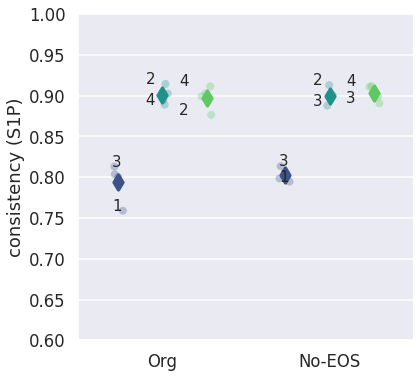

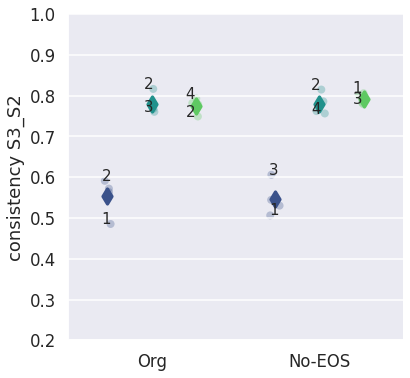

KeyError: 'not_permuted'

<Figure size 432x432 with 0 Axes>

In [319]:
plt.figure(figsize=(6, 6))
sns.stripplot(x=hue, y=s1p_results, hue=models, dodge=True, zorder=1, label=None, alpha=0.3, size=8, palette="viridis")
ax = sns.pointplot(x=hue, y=s1p_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
plt.legend([], [], frameon=False)
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("consistency (S1P)")
plt.ylim(0.6, 1)
for y, x, m, t in s1p_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.1
    if m == "all":
        x += 0.1
    plt.text(x, y, t, fontsize=15)
#plt.savefig("/checkpoint/itayitzhak/figures/s1p.pdf", bbox_inches="tight")
plt.show()


plt.figure(figsize=(6, 6))
ax = sns.pointplot(x=hue, y=s3_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
sns.stripplot(x=hue, y=s3_results, hue=models, dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis")
plt.legend([], [], frameon=False) #["tiny", "small", "all"], bbox_to_anchor=(0.57, 1.05))
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("consistency S3_S2")
plt.ylim(0.2, 1)
for y, x, m, t in s3_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.05
    if m == "all":
        x += 0.2
    plt.text(x, y, t, fontsize=15)
#ax.set_yticks([])
#plt.savefig("/checkpoint/itayitzhak/figures/s3.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(6, 6))
ax = sns.pointplot(x=hue, y=bleu_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
sns.stripplot(x=hue, y=s3_results, hue=models, dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis")
plt.legend([], [], frameon=False) #["tiny", "small", "all"], bbox_to_anchor=(0.57, 1.05))
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["Org", "No-EOS"])
ax.set_ylabel("BLEU")
plt.ylim(20, 26)
for y, x, m, t in bleu_all_annotations:
    if x == "natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"not_permuted": 0, "remove_eos_not_permuted": 1}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.05
    if m == "all":
        x += 0.2
    plt.text(x, y, t, fontsize=15)
#ax.set_yticks([])
#plt.savefig("/checkpoint/itayitzhak/figures/s3.pdf", bbox_inches="tight")
plt.show()

## ORginial

In [263]:
import logging
import pickle
import numpy as np
import editdistance


def get_conjunct(sentence):
    """
    Separate sentence into two parts based on conjunction.
    Args:
        - sentence (str)
    Returns:
        - whether the conjunct was found
        - the conjunct
    """
    conjunction = " en "

    # If conjunct in sentence
    if conjunction in sentence:
        conjunct = sentence.split(conjunction)[1:]
        # If the conjunct is shorter than 3 words you've got the wrong one
        if len(sentence.split(conjunction)[0].split()) < 3:
            conjunct = sentence.split(conjunction)[2:]
        conjunct = conjunction.join(conjunct)
        return True, f"MASK {conjunct}"
    return False, f"MASK {sentence}"


def reorder(lines):
    """
    Reorder lines, since Fairseq shuffles them while translating.
    Order based on the index indicated after "D-...", "S-..." or "H-...".
    
    Args:
        - lines: list of str
    Returns:
        - list of str
    """
    sentences = []
    for line in lines:
        line = line.split("\t")
        if "D-" in line[0]:
            index = int(line[0].split('-')[1])
            sentence = line[2].strip()
            sentences.append((index, sentence))
    _, sentences = zip(*sorted(sentences))
    assert len(sentences) == 500
    return sentences


def compute_systematicity_s_conj(template, data_type, model):
    """
    Compute systematicity consistency scores for the S -> S CONJ S setup.
    Args:
        - template (int): 1 ... 10
        - data_type (str): natural | semi_natural | synthetic
        - model (str): format of "transformer_DATA_SEED"
    Returns:
        - s1p (float): consistency score for the S1 -> S1' condition
        - s3 (float): consistency score for the S1 -> S3 condition
        - trace (dict): mistakes made by the model
    """
    trace = dict()
    condition_s1p = []
    condition_s3 = []
    prefix = f"/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_conj/{data_type}/systematicity_{data_type}_{template}"

    # English source sentences
    with open(f"{prefix}_s1_s2.en", encoding="utf-8") as f:
        srcs = f.readlines()

    # Gather the translation of the regular setup and the two subconditions
    prefix = f"/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_conj/pred_{data_type}/{model}/systematicity_{data_type}_{template}"
    with open(f"{prefix}_s1_s2.nl", encoding="utf-8") as f:
        pred_s1_s2 = reorder(f.readlines())
    with open(f"{prefix}_s1p_s2.nl", encoding="utf-8") as f:
        pred_s1p_s2 = reorder(f.readlines())
    with open(f"{prefix}_s3_s2.nl", encoding="utf-8") as f:
        pred_s3_s2 = reorder(f.readlines())

    for src, first, second, third in zip(srcs, pred_s1_s2, pred_s1p_s2, pred_s3_s2):
        # Ensure that the same type of tokenisation is used 
        found1, first_conjunct = get_conjunct(first)
        found2, second_conjunct = get_conjunct(second)
        found3, third_conjunct = get_conjunct(third)

        # Don't consider sentences where the second conjunct was not found
        if not all([found1, found2, found3]):
            continue

        condition_s1p.append(first_conjunct == second_conjunct)
        condition_s3.append(first_conjunct == third_conjunct)

        # Collect cases where s2 different for s1' and s3 substitutions
        if first_conjunct not in {second_conjunct, third_conjunct}:
            trace[src.strip()] = (first_conjunct, second_conjunct, third_conjunct)

    s1p = np.mean(condition_s1p)
    s3 = np.mean(condition_s3)
    return (s1p, s3), trace


def compute_systematicity_s_np_vp(template, data_type, model):
    """
    Compute systematicity consistency scores for the S -> NP VP setup.
    Args:
        - template (int): 1 ... 10
        - data_type (str): natural | semi_natural | synthetic
        - model (str): format of "transformer_DATA_SEED"
    Returns:
        - score_np (float): consistency score for the NP -> NP' condition
        - score_vp (float): consistency score for the VP -> VP' condition
        - trace (dict): mistakes made by the model
    """
    trace = dict()

    condition_np = []
    condition_vp = []
    prefix = f"/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_np_vp/{data_type}/systematicity_{data_type}_{template}"
    with open(f"{prefix}_np.en", encoding="utf-8") as f:
        srcs = f.readlines()
    prefix = f"/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_np_vp/pred_{data_type}/{model}/systematicity_{data_type}_{template}"
    with open(f"{prefix}_np.nl", encoding="utf-8") as f:
        pred_np = reorder(f.readlines())
    with open(f"{prefix}_np_prime.nl", encoding="utf-8") as f:
        pred_np_prime = reorder(f.readlines())
    if data_type == "synthetic":
        with open(f"{prefix}_vp_prime.nl", encoding="utf-8") as f:
            pred_vp_prime = reorder(f.readlines())

    for k, (src, sent, np_prime) in enumerate(zip(srcs, pred_np, pred_np_prime)):
        sent = sent.replace(" het ", " de ").replace("Het ", "De ")
        np_prime = np_prime.replace(" het ", " de ").replace("Het ", "De ")
        
        condition_np.append(editdistance.eval(sent.split(), np_prime.split()) == 1)
        if editdistance.eval(sent.split(), np_prime.split()) != 1:
            trace[(src.strip(), "np")] = (sent, np_prime)

        if data_type == "synthetic":
            vp_prime = pred_vp_prime[k]
            vp_prime = vp_prime.replace(" het ", " de ").replace("Het ", "De ")
            condition_vp.append(editdistance.eval(sent.split(), vp_prime.split()) == 1)
            if editdistance.eval(sent.split(), vp_prime.split()) != 1:
                trace[(src.strip(), "vp")] = (sent, vp_prime)

    # Report results to user in a format that can easily be copied to tables
    score_np = np.mean(condition_np)
    score_vp = None if data_type != "synthetic" else np.mean(condition_vp)
    return (score_np, score_vp), trace


if __name__ == "__main__":
    results = dict()

    sizes = ["tiny", "small", "all"]
    for size in sizes:
        for seed in [1, 2, 3, 4, 5]:
            model = f"transformer_{size}_{seed}"
            for t in range(1, 11):
                print(model, t)
                for data_type in ["synthetic", "semi_natural", "natural"]:
                    score, _ = compute_systematicity_s_conj(t, data_type, model)
                    results[(model, seed, "s_conj", data_type, t)] = score
                for data_type in ["synthetic", "semi_natural"]:
                    score, _ = compute_systematicity_s_np_vp(t, data_type, model)
                    results[(model, seed, "s_np_vp", data_type, t)] = score

    pickle.dump(results, open("results.pickle", 'wb'))

transformer_tiny_1 1
transformer_tiny_1 2
transformer_tiny_1 3
transformer_tiny_1 4
transformer_tiny_1 5
transformer_tiny_1 6
transformer_tiny_1 7
transformer_tiny_1 8
transformer_tiny_1 9
transformer_tiny_1 10
transformer_tiny_2 1
transformer_tiny_2 2
transformer_tiny_2 3
transformer_tiny_2 4
transformer_tiny_2 5
transformer_tiny_2 6
transformer_tiny_2 7
transformer_tiny_2 8
transformer_tiny_2 9
transformer_tiny_2 10
transformer_tiny_3 1
transformer_tiny_3 2
transformer_tiny_3 3
transformer_tiny_3 4
transformer_tiny_3 5
transformer_tiny_3 6
transformer_tiny_3 7
transformer_tiny_3 8
transformer_tiny_3 9
transformer_tiny_3 10
transformer_tiny_4 1
transformer_tiny_4 2
transformer_tiny_4 3
transformer_tiny_4 4
transformer_tiny_4 5
transformer_tiny_4 6
transformer_tiny_4 7
transformer_tiny_4 8
transformer_tiny_4 9
transformer_tiny_4 10
transformer_tiny_5 1
transformer_tiny_5 2
transformer_tiny_5 3
transformer_tiny_5 4
transformer_tiny_5 5
transformer_tiny_5 6
transformer_tiny_5 7
transform

In [277]:
sns.set_context("talk")
results = pickle.load(open("results.pickle", 'rb'))

s1p_results = []
s3_results = []
models = [] 
hue = []
s1p_all_annotations = []
s3_all_annotations = []

#for data_type in ["synthetic", "semi_natural", "natural"]:
for data_type in ["synthetic"]:
    for model in ["tiny", "small", "all"]:
        s1p_annotations = []
        s3_annotations = []
        for t in range(1, 11):
            size_results = [results[(f"transformer_{model}_{seed}", seed, "s_conj", data_type, t)]
                            for seed in [1, 2, 3, 4, 5]]
            s1p, s3 = zip(*size_results)
            s1p_results.append(np.mean(s1p))
            s3_results.append(np.mean(s3))
            #print(model, data_type, t, np.mean(s3))
            models.append(model)
            hue.append(data_type)
            s1p_annotations.append((np.mean(s1p), data_type, model, t))
            s3_annotations.append((np.mean(s3), data_type, model, t))
        s3_all_annotations.append(min(s3_annotations))
        s3_all_annotations.append(max(s3_annotations))
        s1p_all_annotations.append(min(s1p_annotations))
        s1p_all_annotations.append(max(s1p_annotations))

KeyError: 0

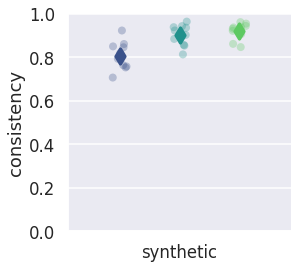

In [278]:
plt.figure(figsize=(4, 4))
sns.stripplot(x=hue, y=s1p_results, hue=models, dodge=True, zorder=1, label=None, alpha=0.3, size=8, palette="viridis")
ax = sns.pointplot(x=hue, y=s1p_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
plt.legend([], [], frameon=False)
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["synthetic"])
ax.set_ylabel("consistency")
plt.ylim(0.0, 1)
for y, x, m, t in s1p_all_annotations:
    if x == "natural"  or x == "semi_natural":
        continue
    x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"synthetic": 0}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.1
    if m == "all":
        x += 0.1
    plt.text(x, y, t, fontsize=15)
#plt.savefig("figures/s1p.pdf", bbox_inches="tight")
plt.show()


plt.figure(figsize=(4, 4))
ax = sns.pointplot(x=hue, y=s3_results, hue=models,
              dodge=.532, join=False, 
              markers="d", scale=1.05, ci=None, palette="viridis")
sns.stripplot(x=hue, y=s3_results, hue=models, dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis")
plt.legend([], [], frameon=False) #["tiny", "small", "all"], bbox_to_anchor=(0.57, 1.05))
sns.despine(top=True, right=True)
#ax.set_xticklabels(["synthetic", "semi-n.", "natural"])
ax.set_xticklabels(["synthetic"])
ax.set_ylabel("consistency")
plt.ylim(0.0, 1)
for y, x, m, t in s3_all_annotations:
    if x == "natural" or x == "semi_natural":
        continue
    #x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    x = {"synthetic": 0}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.05
    if m == "all":
        x += 0.2
    plt.text(x, y, t, fontsize=15)
#ax.set_yticks([])
#plt.savefig("figures/s3.pdf", bbox_inches="tight")
plt.show()

In [108]:
def change_for_plot(string):
    if string == 'trained_data_type': return 'Training Data Type'
    if string == 'not_permuted_without_eos': return 'Trained With Original Data'
    if string == 'not_permuted': return 'Trained With Original Data (Analysis With EOS)'
    if string == 'remove_eos_not_permuted': return 'Trained Without EOS'
    if string == 'model_distance_weighted_median': return 'Distance Weighted Median'
    if string == 'model_globality_scores': return 'Globality'
    if string == 'trained_data_size': return 'Data Size'
    if string == 'model_bleu': return 'BLEU'
    if string == 'distance_weighted_median': return 'Distance Weighted Median Distrubation'     
    if string == 's_conj_s1p_s2_consist': return 's_conj s1p_s2 Consistency'  
    if string == 's_conj_s3_s2_consist': return 's_conj s3_s2 Consistency'
    if string == 's_np_vp_np_prime_consist': return 's_np_vp np_prime Consistency'
    if string == 's_np_vp_vp_prime_consist': return 's_np_vp vp_prime Consistency'
 
    return string

def create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds, templates_to_use):
    data_to_plot = dict()
    for wanted_key in wanted_keys:
        data_to_plot[change_for_plot(wanted_key)] = []
    data_to_plot['model_name'] = []
        
    for cur_model_path, results in models_final_results.items():
        if results['conds'] == wanted_conds and results['template'] in templates_to_use:
            # print(f"cur_model_path:{cur_model_path}")
            data_to_plot['model_name'].append(cur_model_path)
            for key, value in results.items():
                #print(key)
                if key in wanted_keys:
                    data_to_plot[change_for_plot(key)].append(change_for_plot(value))
    
#     for key,value in data_to_plot.items():
#         print(f"key={key}")
#         print(f"value={value}")
#         print(f"len(value)={len(value)}")
#         print(f"type(value)={type(value)}")
#         print("*"*20)
    #models_names = [x.split('\\')[-1] for x in list(models_final_results.keys())]
    models_names = list(data_to_plot['model_name'])
    #print(f"models_names:{models_names}")
    #print(f"data_to_plot:{data_to_plot}")
    data_to_plot = pd.DataFrame(data_to_plot, index = models_names)
    data_to_plot = data_to_plot.explode(wanted_y)
    
#     print(f"data_to_plot[wanted_y].head():{data_to_plot[wanted_y].head()}")
#     print(f"len(data_to_plot):{len(data_to_plot)}")

    return data_to_plot

In [123]:
def get_bar_plot(models_final_results, wanted_keys, wanted_y, ylim, wanted_conds=('s_conj','s1_s2'),templates_to_use=[i for i in range(1,11)]):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds, templates_to_use)
    sns.set_context('paper')
    sns.set(rc={'figure.figsize':(8,4)})
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.tight_layout()
    sns.set(font_scale=0.8)
    plt.ylim(ylim[0], ylim[1])
    
#     ax = sns.barplot(x = 'Data Size', y = wanted_y, data = data_to_plot,
#             palette = 'hls', hue = 'Training Data Type',
#             #order = ['trained_data_size'],#['tiny', 'small', 'all'],  
#             capsize = 0.05,             
#             saturation = 12,             
#             errcolor = 'gray', errwidth = 2,  
#             ci = 'sd'   
#             )
    ax = sns.scatterplot(x = 'Data Size', y = wanted_y, hue = 'Training Data Type', data = data_to_plot, s=80)
    plt.show()

No handles with labels found to put in legend.


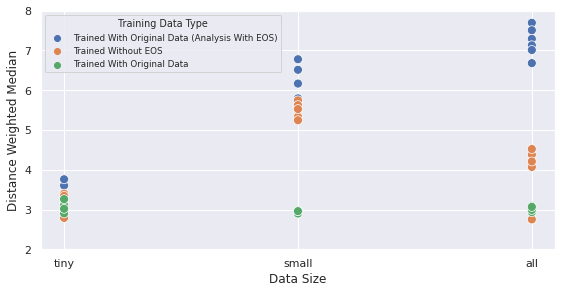

No handles with labels found to put in legend.


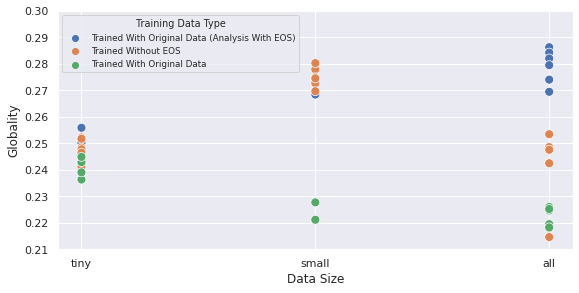

No handles with labels found to put in legend.


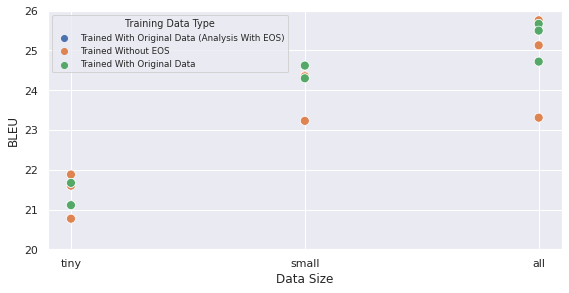

In [124]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Distance Weighted Median', ylim=(2,8),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Globality', ylim=(0.21,0.3),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_bleu'],
             wanted_y='BLEU', ylim=(20,26),
             wanted_conds = ('s_conj','s1_s2')
            )


No handles with labels found to put in legend.


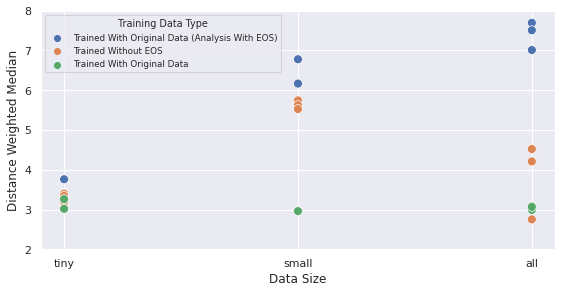

No handles with labels found to put in legend.


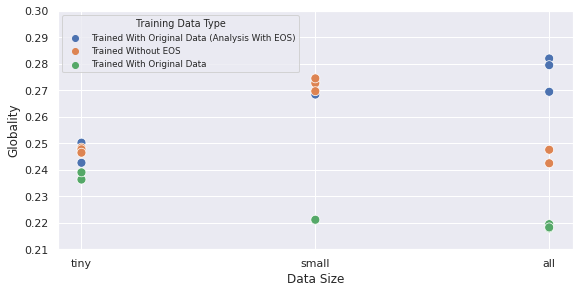

No handles with labels found to put in legend.


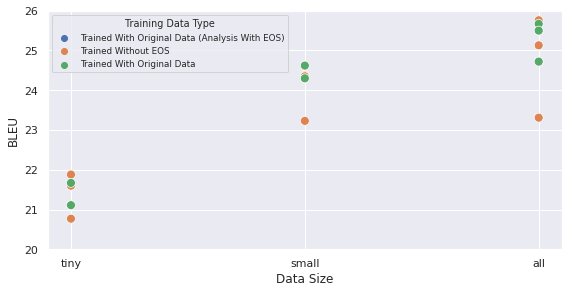

In [125]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Distance Weighted Median', ylim=(2,8),
             wanted_conds = ('s_conj','s1_s2'),
             templates_to_use=[2]
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_distance_weighted_median','model_globality_scores'],
             wanted_y='Globality', ylim=(0.21,0.3),
             wanted_conds = ('s_conj','s1_s2'),
             templates_to_use=[2]
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','model_bleu'],
             wanted_y='BLEU', ylim=(20,26),
             wanted_conds = ('s_conj','s1_s2'),
             templates_to_use=[2]
            )

No handles with labels found to put in legend.


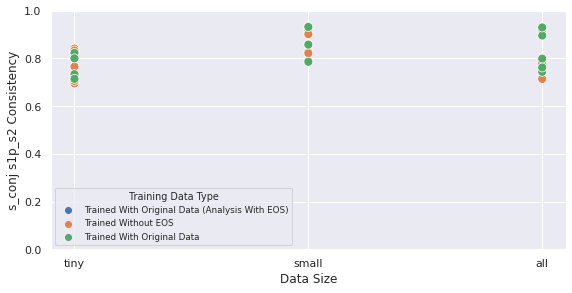

No handles with labels found to put in legend.


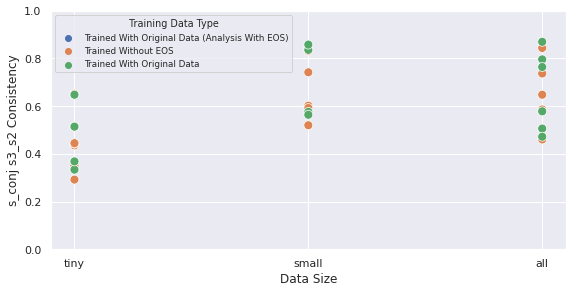

No handles with labels found to put in legend.


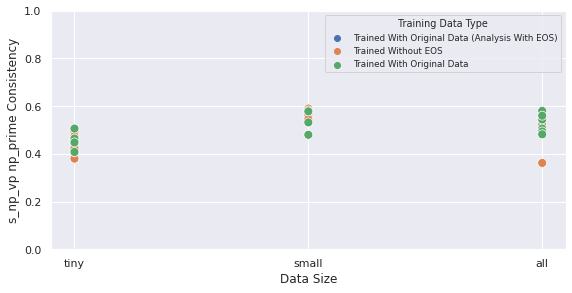

No handles with labels found to put in legend.


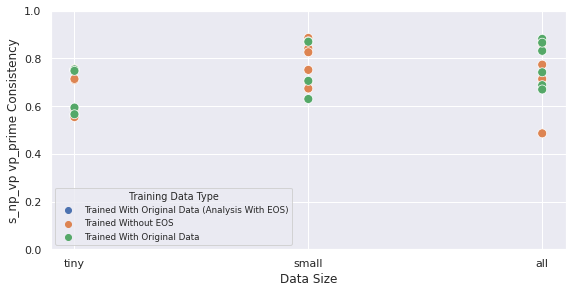

In [126]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s1p_s2_consist'],
             wanted_y='s_conj s1p_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s3_s2_consist'],
             wanted_y='s_conj s3_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )


get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_np_prime_consist'],
             wanted_y='s_np_vp np_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_vp_prime_consist'],
             wanted_y='s_np_vp vp_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

No handles with labels found to put in legend.


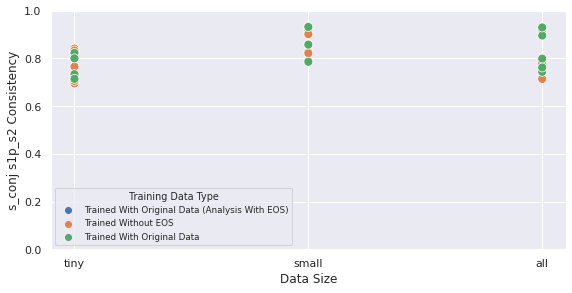

No handles with labels found to put in legend.


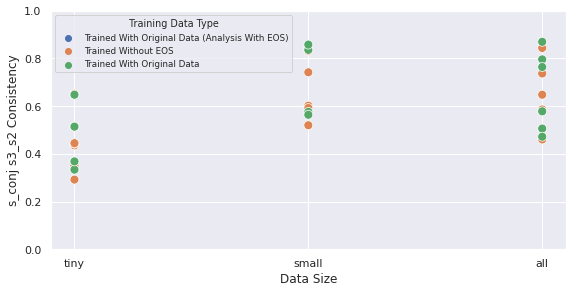

No handles with labels found to put in legend.


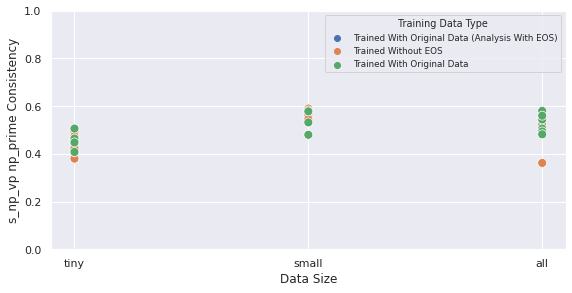

No handles with labels found to put in legend.


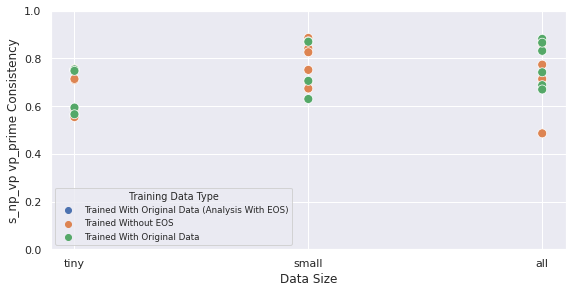

In [127]:
get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s1p_s2_consist'],
             wanted_y='s_conj s1p_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_conj_s3_s2_consist'],
             wanted_y='s_conj s3_s2 Consistency', ylim=(0,1),
             wanted_conds = ('s_conj','s1_s2')
            )


get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_np_prime_consist'],
             wanted_y='s_np_vp np_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

get_bar_plot(all_models_final_results,
             ['trained_data_type','trained_data_size','s_np_vp_vp_prime_consist'],
             wanted_y='s_np_vp vp_prime Consistency', ylim=(0,1),
             wanted_conds = ('s_np_vp','np')
            )

### Ferna's Plots

In [287]:
import logging
import pickle
import numpy as np
import editdistance


def get_conjunct(sentence):
    """
    Separate sentence into two parts based on conjunction.
    Args:
        - sentence (str)
    Returns:
        - whether the conjunct was found
        - the conjunct
    """
    conjunction = " en "

    # If conjunct in sentence
    if conjunction in sentence:
        conjunct = sentence.split(conjunction)[1:]
        # If the conjunct is shorter than 3 words you've got the wrong one
        if len(sentence.split(conjunction)[0].split()) < 3:
            conjunct = sentence.split(conjunction)[2:]
        conjunct = conjunction.join(conjunct)
        return True, f"MASK {conjunct}"
    return False, f"MASK {sentence}"


def reorder(lines):
    """
    Reorder lines, since Fairseq shuffles them while translating.
    Order based on the index indicated after "D-...", "S-..." or "H-...".
    
    Args:
        - lines: list of str
    Returns:
        - list of str
    """
    sentences = []
    for line in lines:
        line = line.split("\t")
        if "D-" in line[0]:
            index = int(line[0].split('-')[1])
            sentence = line[2].strip()
            sentences.append((index, sentence))
    _, sentences = zip(*sorted(sentences))
    assert len(sentences) == 500
    return sentences


def compute_systematicity_s_conj(template, seed, expirement_data_type, text_type, data_size):
    """
    Compute systematicity consistency scores for the S -> S CONJ S setup.
    Args:
        - template (int): 1 ... 10
        - data_type (str): natural | semi_natural | synthetic
        - model (str): format of "transformer_DATA_SEED"
    Returns:
        - s1p (float): consistency score for the S1 -> S1' condition
        - s3 (float): consistency score for the S1 -> S3 condition
        - trace (dict): mistakes made by the model
    """
    trace = dict()
    condition_s1p = []
    condition_s3 = []
    #prefix = f"s_conj/{data_type}/systematicity_{data_type}_{template}"
    home_dir = '/checkpoint/itayitzhak/attn_weigths/'
    source_file_prefix = f'/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_conj/{text_type}/systematicity_synthetic_{template}'

    # English source sentences
#     with open(f"{prefix}_s1_s2.en", encoding="utf-8") as f:
#         srcs = f.readlines()
    with open(f"{source_file_prefix}_s1_s2.en", encoding="utf-8") as f:
        srcs = f.readlines()
    
    # Gather the translation of the regular setup and the two subconditions
    # prefix = f"s_conj/pred_{data_type}/{model}/systematicity_{data_type}_{template}"
    #with open(f"{prefix}_s1_s2.nl", encoding="utf-8") as f:
    with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s1_s2_{data_size}/generate-test.txt", encoding="utf-8") as f:
        pred_s1_s2 = reorder(f.readlines())
    #with open(f"{prefix}_s1p_s2.nl", encoding="utf-8") as f:
    with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s1p_s2_{data_size}/generate-test.txt", encoding="utf-8") as f:
        pred_s1p_s2 = reorder(f.readlines())
    #with open(f"{prefix}_s3_s2.nl", encoding="utf-8") as f:
    with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_conj_{text_type}_systematicity_{text_type}_{template}_s3_s2_{data_size}/generate-test.txt", encoding="utf-8") as f:
        pred_s3_s2 = reorder(f.readlines())

    for src, first, second, third in zip(srcs, pred_s1_s2, pred_s1p_s2, pred_s3_s2):
        # Ensure that the same type of tokenisation is used 
        found1, first_conjunct = get_conjunct(first)
        found2, second_conjunct = get_conjunct(second)
        found3, third_conjunct = get_conjunct(third)

        # Don't consider sentences where the second conjunct was not found
        if not all([found1, found2, found3]):
            continue

        condition_s1p.append(first_conjunct == second_conjunct)
        condition_s3.append(first_conjunct == third_conjunct)

        # Collect cases where s2 different for s1' and s3 substitutions
        if first_conjunct not in {second_conjunct, third_conjunct}:
            trace[src.strip()] = (first_conjunct, second_conjunct, third_conjunct)

    s1p = np.mean(condition_s1p)
    s3 = np.mean(condition_s3)
    return (s1p, s3), trace


def compute_systematicity_s_np_vp(template, seed, expirement_data_type, text_type, data_size):
    """
    Compute systematicity consistency scores for the S -> NP VP setup.
    Args:
        - template (int): 1 ... 10
        - data_type (str): natural | semi_natural | synthetic
        - model (str): format of "transformer_DATA_SEED"
    Returns:
        - score_np (float): consistency score for the NP -> NP' condition
        - score_vp (float): consistency score for the VP -> VP' condition
        - trace (dict): mistakes made by the model
    """
    trace = dict()
    condition_np = []
    condition_vp = []
    # prefix = f"s_np_vp/{data_type}/systematicity_{data_type}_{template}"
    #with open(f"{prefix}_np.en", encoding="utf-8") as f:
    home_dir = '/checkpoint/itayitzhak/attn_weigths/'
    source_file_prefix = f'/private/home/dieuwkehupkes/nmt/compositional_mt/systematicity/s_np_vp/{text_type}/systematicity_synthetic_{template}'
    with open(f"{source_file_prefix}_np.en", encoding="utf-8") as f:
        np_srcs = f.readlines()
    #with open(f"{prefix}_np_prime.en", encoding="utf-8") as f:
    with open(f"{source_file_prefix}_np_prime.en", encoding="utf-8") as f:   
        np_srcs_prime = f.readlines()
    if text_type == "synthetic":
        #with open(f"{prefix}_vp_prime.en", encoding="utf-8") as f:
        with open(f"{source_file_prefix}_vp_prime.en", encoding="utf-8") as f:
            vp_srcs_prime = f.readlines()
    
    # prefix = f"s_np_vp/pred_{data_type}/{model}/systematicity_{data_type}_{template}"
    #with open(f"{prefix}_np.nl", encoding="utf-8") as f:
    with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_np_vp_{text_type}_systematicity_{text_type}_{template}_np_{data_size}/generate-test.txt", encoding="utf-8") as f:
        pred_np = reorder(f.readlines())
    #with open(f"{prefix}_np_prime.nl", encoding="utf-8") as f:
    with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_np_vp_{text_type}_systematicity_{text_type}_{template}_np_prime_{data_size}/generate-test.txt", encoding="utf-8") as f:
        pred_np_prime = reorder(f.readlines())
    if text_type == "synthetic":
        #with open(f"{prefix}_vp_prime.nl", encoding="utf-8") as f:
        with open(f"{home_dir}{expirement_data_type}_seed_{seed}_compositional_mt_systematicity_s_np_vp_{text_type}_systematicity_{text_type}_{template}_vp_prime_{data_size}/generate-test.txt", encoding="utf-8") as f:
            pred_vp_prime = reorder(f.readlines())

    for k, (src, src_prime, sent, np_prime) in enumerate(zip(np_srcs, np_srcs_prime, pred_np, pred_np_prime)):
        sent = sent.replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
        np_prime = np_prime.replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
        
        condition_np.append(editdistance.eval(sent.split(), np_prime.split()) == 1)
        if editdistance.eval(sent.split(), np_prime.split()) != 1:
            trace[(src.strip(), src_prime, "np")] = (sent, np_prime)

        if text_type == "synthetic":
            vp_prime = pred_vp_prime[k].replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
            vp_prime = vp_prime.replace(" het ", " de ").replace("Het ", "De ").replace(" dat ", " die ")
            condition_vp.append(editdistance.eval(sent.split(), vp_prime.split()) == 1)
            if editdistance.eval(sent.split(), vp_prime.split()) != 1:
                trace[(np_srcs[k].strip(), vp_srcs_prime[k], "vp")] = (sent, vp_prime)

    # Report results to user in a format that can easily be copied to tables
    score_np = np.mean(condition_np)
    score_vp = None if text_type != "synthetic" else np.mean(condition_vp)
    return (score_np, score_vp), trace


# if __name__ == "__main__":
#     results = dict()

#     sizes = ["tiny", "small", "all"]
#     for size in sizes:
#         for seed in [1, 2, 3, 4, 5]:
#             model = f"transformer_{size}_{seed}"
#             for t in range(1, 11):
#                 print(model, t)
#                 for data_type in ["synthetic", "semi_natural", "natural"]:
#                     score, trace_conj = compute_systematicity_s_conj(t, data_type, model)
#                     results[(model, seed, "s_conj", data_type, t)] = score
                
#                 for data_type in ["synthetic", "semi_natural"]:
#                     score, trace_np_vp = compute_systematicity_s_np_vp(t, data_type, model)
#                     results[(model, seed, "s_np_vp", data_type, t)] = score
#     pickle.dump(results, open("results.pickle", 'wb'))

seed = 1
template = 1
expirement_data_type = 'not_permuted'
text_type = 'synthetic'
data_size = 'small'

nums, _ = compute_systematicity_s_conj(template, seed, expirement_data_type, text_type, data_size)
print(nums)
nums, _ = compute_systematicity_s_np_vp(template, seed, expirement_data_type, text_type, data_size)
print(nums)

(0.926, 0.866)
(0.562, 0.868)


key=Training Data Type
********************
key=Data Size
********************
key=Distance Weighted Median Distrubation
********************


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (9).

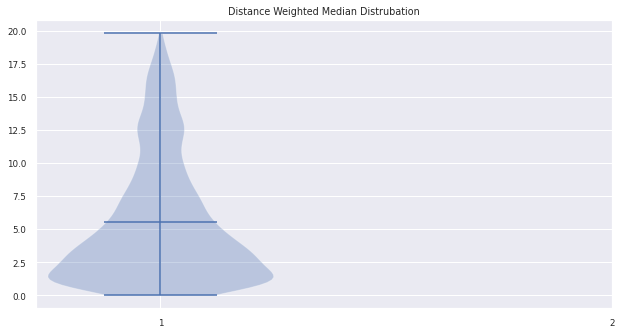

In [190]:
def show_violin_new(models_final_results, wanted_keys, wanted_y, wanted_conds=('s_conj','s1_s2')):
    data_to_plot = create_df_from_results(models_final_results, wanted_keys, wanted_y, wanted_conds)
    labels = (data_to_plot['Training Data Type'] + data_to_plot['Data Size']).unique()
    dists = list(data_to_plot[wanted_y])
    fig = plt.figure()
    ax1 = fig.add_axes([0,0,1,1])
    #print(f"dists:{dists}")
    bp_eos = ax1.violinplot(dists, showmeans=True)
    ax1.set_title(wanted_y)
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(labels, rotation=0)

    plt.show()

show_violin_new(
    all_models_final_results,
    ['trained_data_type','trained_data_size','distance_weighted_median'],
    'Distance Weighted Median Distrubation', wanted_conds=('s_conj','s1_s2'))

In [ ]:
def show_violin(dists, title, labels):
    # df_all_eos_foucesed_heads = pd.DataFrame(all_eos_foucesed_heads).transpose()
    # ax = sns.violinplot(x=["a", "b"],data=df_all_eos_foucesed_heads)

    # Create a figure instance
    fig = plt.figure()

    #fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,6), sharex=False)

    # Create an axes instance
    ax1 = fig.add_axes([0,0,1,1])
    # ax2 = fig.add_axes([0,0,1,1])
    # ax3 = fig.add_axes([0,0,1,1])

    # Create the boxplot
    #ax1.xlabels(["a","b","c","a","b","c"])
    bp_eos = ax1.violinplot(dists, showmeans=True)

    # plt.show()
    # bp = ax.violinplot(all_distance_weighted_median)
    # plt.show()
    # bp = ax.violinplot(all_globality_scores)
    ax1.set_title(title)

    #ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)
    ax1.set_xticks([1,2])
    ax1.set_xticklabels(labels, rotation=0)

    plt.show()

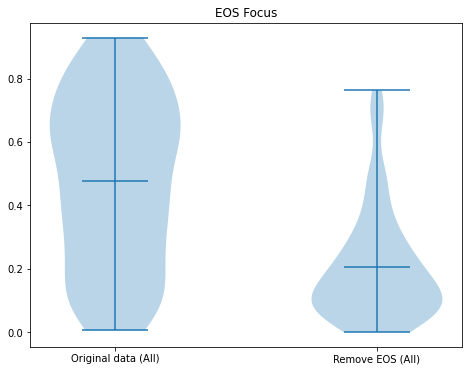

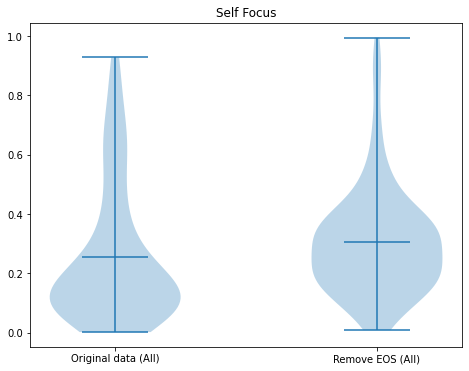

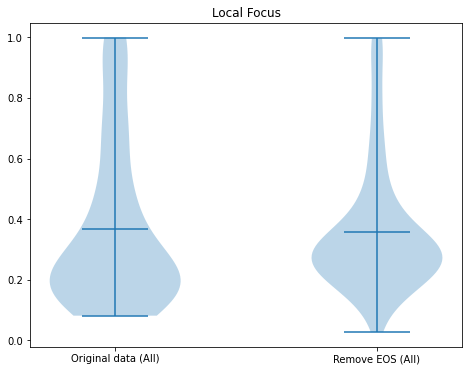

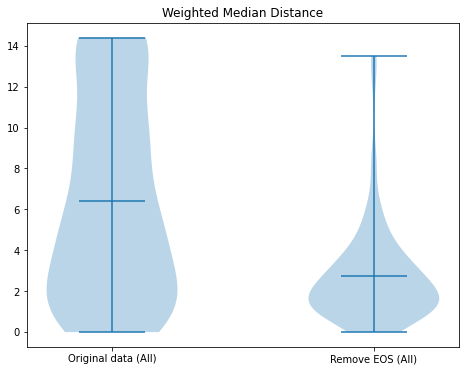

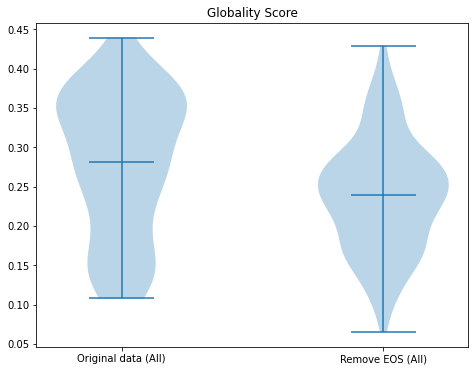

In [480]:
show_violin(all_eos_foucesed_heads, 'EOS Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_self_heads, 'Self Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_local_heads, 'Local Focus', ["Original data (All)","Remove EOS (All)"])
show_violin(all_distance_weighted_median, 'Weighted Median Distance', ["Original data (All)","Remove EOS (All)"])
show_violin(all_globality_scores, 'Globality Score', ["Original data (All)","Remove EOS (All)"])

In [485]:
def print_single_ttest(H_0,H_1,name_1,name_2):
    print(f"T-test for {name_1} vs {name_2}",end=':')
    print(f"p-value <= {stats.ttest_ind(H_0, H_1)[1]:.4f}")
    
def calc_ttest(data_for_ttest):
#     print("T-test for Not Permuted vs 5-gram Permuted (Small)",end=':')
#     print(f"p-value <= {stats.ttest_ind(data_for_ttest[0], data_for_ttest[1])[1]:.2f}")
    print_single_ttest(data_for_ttest[0],data_for_ttest[1],"Not Permuted","5-gram Permuted (Small)")
    print("T-test for Not Permuted vs Permuted (Small)",end=':')
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[0], data_for_ttest[2])[1]:.2f}")
    print("T-test for Not Permuted vs 5-gram Permuted (All)",end=':')
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[3], data_for_ttest[4])[1]:.2f}")
    print("T-test for Not Permuted vs Permuted (All)",end=':')
    #print(stats.ttest_ind(all_distance_weighted_median[3], all_distance_weighted_median[5]))
    print(f"p-value <= {stats.ttest_ind(data_for_ttest[3], data_for_ttest[5])[1]:.2f}")
# calc_ttest(all_distance_weighted_median)


In [486]:
print_single_ttest(all_eos_foucesed_heads[0],all_eos_foucesed_heads[1],"EOS Original data (All)","EOS Remove EOS (All)")
print_single_ttest(all_self_heads[0],all_self_heads[1],"SELF Original data (All)"," SELF Remove EOS (All)")
print_single_ttest(all_local_heads[0],all_local_heads[1],"LOCAL Original data (All)","Local Remove EOS (All)")
print_single_ttest(all_distance_weighted_median[0],all_distance_weighted_median[1],"Weighted Distance Original data (All)","Weighted Distance Remove EOS (All)")
print_single_ttest(all_globality_scores[0],all_globality_scores[1],"Globality Original data (All)","Gloablity Remove EOS (All)")

T-test for EOS Original data (All) vs EOS Remove EOS (All):p-value <= 0.0000
T-test for SELF Original data (All) vs  SELF Remove EOS (All):p-value <= 0.0398
T-test for LOCAL Original data (All) vs Local Remove EOS (All):p-value <= 0.6598
T-test for Weighted Distance Original data (All) vs Weighted Distance Remove EOS (All):p-value <= 0.0000
T-test for Globality Original data (All) vs Gloablity Remove EOS (All):p-value <= 0.0000


<ipython-input-382-d8c9eed61aa8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)


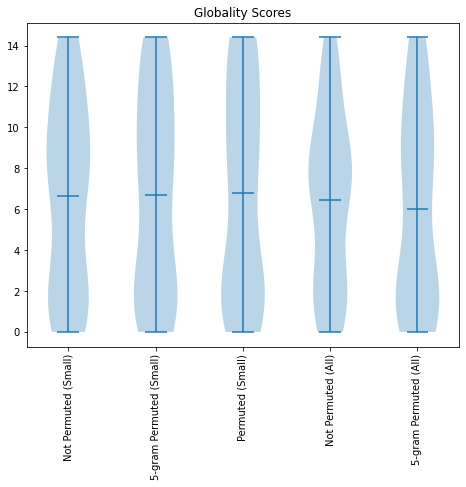

In [382]:
# df_all_eos_foucesed_heads = pd.DataFrame(all_eos_foucesed_heads).transpose()
# ax = sns.violinplot(x=["a", "b"],data=df_all_eos_foucesed_heads)

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax1 = fig.add_axes([0,0,1,1])

# Create the boxplot
bp_eos = ax1.violinplot(all_seeds_distance_weighted_median, showmeans=True)

ax1.set_title('Globality Scores')
ax1.set_xticklabels(["0","Not Permuted (Small)","5-gram Permuted (Small)","Permuted (Small)","Not Permuted (All)","5-gram Permuted (All)","Permuted (All)"], rotation=90)

plt.show()

Attention Weight threshold is: 0.35.
Majority threshold is: 0.9.
For data "s_conj" "s1_s2" Training_data_size="all" with sentences in Length="20" the measures are:
Percentage of EOS focused heads:  0.00%
Percentage of self focused heads: 5.56%
Percentage of Local focused heads: 5.56%


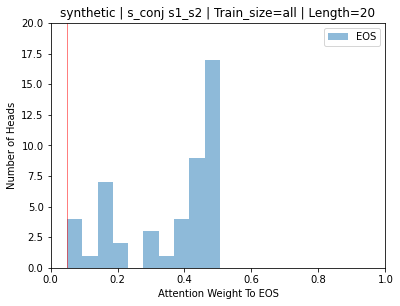

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [507]:
weight_threshold = 0.35 # 2*1/LENGTH
majority_threshold = 0.9
eos_foucesed_heads, self_heads, local_heads, distance_weighted_median, globality_scores = calc_percentage_of_attn_head_type(avg_attn_matrix, weight_threshold, majority_threshold)

#print(eos_foucesed_heads)
#plt.hist(eos_foucesed_heads, np.unique(eos_foucesed_heads), alpha=0.5, label='EOS')
#plt.hist(local_heads, np.unique(local_heads), alpha=0.5, label='Self')
plt.hist(eos_foucesed_heads, alpha=0.5, label='EOS', histtype='bar')
#plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar')
#plt.hist(local_heads, alpha=0.5, label='Local', histtype='bar')

plt.legend(loc='upper right')
#plt.xticks([i for i in range(0,17)])
plt.ylabel('Number of Heads')
plt.xlabel('Attention Weight To EOS')
plt.ylim(0,20)
plt.xlim(0,1.0)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")

plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)
#plt.plot([1/LENGTH]*len(local_heads), label='Uniform Weight')


plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"EOS_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

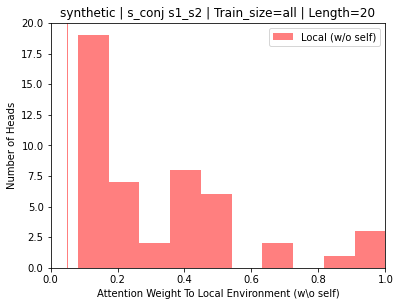

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [508]:
plt.hist(local_heads, alpha=0.5, label='Local (w/o self)', histtype='bar', color='red')
plt.legend(loc='upper right')

plt.ylabel('Number of Heads')
plt.xlabel('Attention Weight To Local Environment (w\o self)')
plt.ylim(0,20)
plt.xlim(0,1.0)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")

plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)


plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Local_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

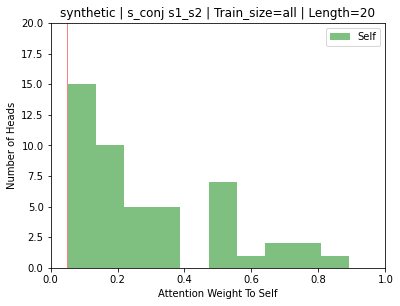

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [509]:
plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar', color='green')
plt.legend(loc='upper right')

plt.ylabel('Number of Heads')
plt.xlabel('Attention Weight To Self')
plt.ylim(0,20)
plt.xlim(0,1.0)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")

plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)


plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Self_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

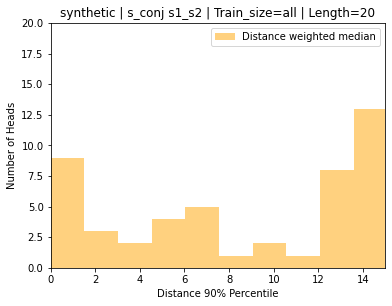

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [510]:
plt.hist(distance_weighted_median, alpha=0.5, label='Distance weighted median', histtype='bar', color='orange')
plt.legend(loc='upper right')
plt.ylabel('Number of Heads')
plt.xlabel('Distance 90% Percentile')
plt.ylim(0,20)
plt.xlim(0,15)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")
plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Distance_weighted_median_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

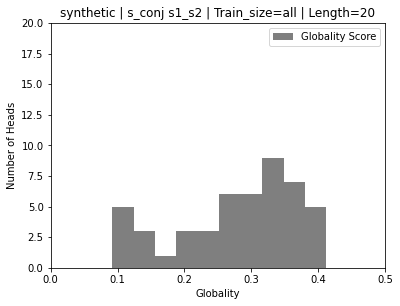

Model:/checkpoint/itayitzhak/attn_weigths/bos_and_eos_at_the_end_seed_1_compositional_mt_systematicity_s_conj_synthetic_systematicity_synthetic_1_s1_s2_all


In [511]:
plt.hist(globality_scores, alpha=0.5, label='Globality Score', histtype='bar', color='black')
plt.legend(loc='upper right')
plt.ylabel('Number of Heads')
plt.xlabel('Globality')
plt.ylim(0,20)
plt.xlim(0,0.5)
plt.title(f"{data_type} | {cond} {cond_name} | Train_size={size} | Length={LENGTH}")
plt.show()
print(f"Model:{cur_model_path}")
#plt.savefig(f"Distance_weighted_median_{cond}_{cond_name}_Train_size={size}_Length={LENGTH}.pdf", bbox_inches='tight')

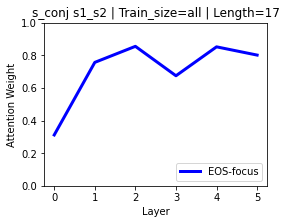

In [1627]:
def display_focus_across_layers(cur_focus, label, color='blue'):
    layer_mean = []
    layer_percentile = []
    for i in range(0,NUM_LAYERS*NUM_HEADS,NUM_HEADS):
        layer_mean.append(sum(cur_focus[i:i+NUM_HEADS]) / NUM_HEADS)
        layer_percentile.append(np.percentile(cur_focus[i:i+NUM_HEADS], 90))

    plt.plot(layer_percentile, alpha=1, label=label, color=color, linewidth=3)
    #plt.hist(self_heads, alpha=0.5, label='Self', histtype='bar')
    #plt.hist(local_heads, alpha=0.5, label='Local', histtype='bar')

    plt.legend(loc='lower right')
    #plt.xticks([i for i in range(0,17)])
    plt.ylabel('Attention Weight')
    plt.xlabel('Layer')
    plt.ylim(0,1.0)
    if label == 'Median Distance': # weighted median distance
        plt.ylim(0,15)
    plt.title(f"{cond} {cond_name} | Train_size={size} | Length={LENGTH}")

    #plt.axvline(x=1/LENGTH, color='red', linewidth=0.5)
    #plt.plot([1/LENGTH]*len(local_heads), label='Uniform Weight')


    plt.show()

    print(f"Model:{cur_model_path}")
display_focus_across_layers(eos_foucesed_heads, label='EOS-focus')

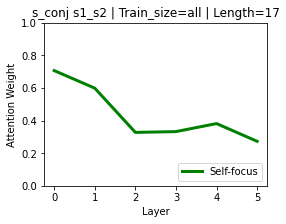

In [1628]:
display_focus_across_layers(self_heads, label='Self-focus', color='green')

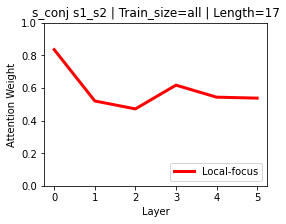

In [1629]:
display_focus_across_layers(local_heads, label='Local-focus', color='red')

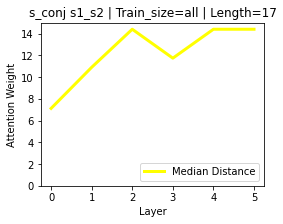

In [1630]:
display_focus_across_layers(distance_weighted_median, label='Median Distance', color='yellow')

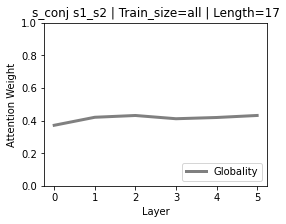

In [1631]:
display_focus_across_layers(globality_scores, label='Globality', color='grey')

In [409]:
# all_gm_scores = []
# all_w_median_scores = []
# for sample_num in range(samples_range[0], samples_range[1]):
#     print(f"sample_num: {sample_num}", end=',')
#     for i in range(NUM_LAYERS):
#         for j in range(NUM_HEADS):
#             gm_score, w_median = display_sample(i, j, sample_num, all_samples, cur_model_path, print_out=False)
#             all_gm_scores.append((gm_score,sample_num,i,j))
#             all_w_median_scores.append((w_median,sample_num,i,j))

# from heapq import nlargest, nsmallest

# def display_multipule_sample(samples_tuple_list):
#     for sample_tuple in samples_tuple_list:
#         display_sample(sample_tuple[2], sample_tuple[3], sample_tuple[1], all_samples, cur_model_path, print_out=True)
#         print("="*120)

# # k_top = 3
# # display_list = [*nsmallest(k_top,all_gm_scores, key=lambda t: t[0]),
# #                 *nsmallest(k_top,all_w_median_scores, key=lambda t: t[0]),
# #                 *nlargest(k_top,all_gm_scores, key=lambda t: t[0]),
# #                 *nlargest(k_top,all_w_median_scores, key=lambda t: t[0])] 

# display_list = [x for x in all_gm_scores if x[0]>=0.0 and x[0] <0.3]

# print(f"Model:{cur_model_path}")
# display_multipule_sample(display_list)

# scores_of_interest = [x for x in all_gm_scores if x[0]>=0.3 and x[0] <0.5]
# sns.heatmap(get_avg_attn_matrix_across_heads(scores_of_interest, cur_model_path, ignore_eos=True))

# plt.hist([x[0] for x in all_w_median_scores], alpha=1.0, label='Weighted Median', histtype='bar')
# plt.legend()

# plt.hist([x[0] for x in all_gm_scores], alpha=0.5, label='Weighted Mean', histtype='bar', color='green')
# plt.legend()

# # - Get the median weighted distance (mwd) 
# # for the eos token attention for every head in every layer,
# # for every sample, plot these values in a scatter plot,
# # plotted against the layer number (so every point would be (mwd, layer number))

# df = pd.DataFrame([(x[0],x[2]) for x in all_w_median_scores], columns=['WMD', 'Layers'])
# sns.catplot(x="Layers", y="WMD", data=df)

NameError: name 'samples_range' is not defined